### 0.코드북 기반 데이터 전처리

#### 0-1) 필요한 모듈 불러오기

In [71]:
# 코랩에 구글 드라이브 마운트
from google.colab import drive
drive.mount("/content/drive")

# 데이터 처리 모듈
import pandas as pd
import datetime
from dateutil.relativedelta import relativedelta

# 멀티프로세싱
import multiprocessing as mp

# 척도 변환 모듈(표준화, 정규화, 로버스트 정규화, 원핫인코딩(범주형에서 더미변수로 변환) 등)
from sklearn.preprocessing import *

# 결측값 관측 모듈
import missingno as msno

# 시각화 모듈
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from matplotlib.ticker import ScalarFormatter

# 배열, 행렬 연산 모듈
import numpy as np

# 데이터 분할 모듈(훈련용 / 검증용 / 시험용)
from sklearn.model_selection import train_test_split

# 통계적 가설검정 및 계량화 모듈
# https://youtu.be/FtWEZw3kUho
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from scipy.interpolate import UnivariateSpline

# 타입 어노테이션 모듈
from typing import *

# 시간 관련 모듈
from tqdm import tqdm
from time import strptime, sleep

# 웹크롤링 / 스크래핑 관련 모듈
import requests
import io
import zipfile
from bs4 import BeautifulSoup
from xml.etree import ElementTree as ET

# 결측값 대체 및 특징 추출
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA, SparsePCA

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 0-2) 데이터 상세 기반 문제 정의 및 기획 방향 설정 | 탐색적 데이터 분석(EDA)

In [ ]:
class LoadData():

# 클래스(로컬공간) 내부에서 cs_data, apy_itm_hist_dat, market_index_data의 값
# 생성자를 활용하여 초기화하고 클래스 내부에 캡슐화
  def __init__(self,
               cs_data_path: str, apy_itm_hist_path: str, market_index_path: str):
    # 용량이 큰 csv 파일 읽어오기(fopen - fread와 유사한 방식)
    cs_chunk = pd.read_csv(cs_data_path, chunksize = 10**5, index_col = False, na_values = "NaN", encoding = "utf-8")
    self.cs_data = list(cs_chunk)
    self.apy_itm_hist_data = pd.read_csv(apy_itm_hist_path, index_col = False, na_values = "NaN", encoding = "utf-8")
      # [BAS_YM] (19.12 ~ 23.04) 기준연월
      # [APY_ITM] (19.12 ~ 23.04)간 공모주 청약 진행된 종목 번호
      # [APY_FIN_YM] 이전 3년(19.12 ~ 22.11)간 마지막으로 참여한 공모주 청약연월(X)
      # [APY_ITM_CNT] 이전 3년(19.12 ~ 22.11)간 공모주 청약에 참여한 종목 개수(X)
    self.market_index_data = pd.read_csv(market_index_path, index_col = False, na_values = "NaN", encoding = "utf-8")


# parallelDataFrame()
# csv(쉼표로 분할된) 데이터 로드 시 병렬처리하는 메서드
# 실제로 수행할 정도로 데이터 크기가 크지는 않고 100,000행씩 chunking하면 해결됨
  def parallelDataFrame(self, data, function):
    # 코어 수 확인(multiprocessing as mp)
    mp.cpu_count()
    # 코어 수를 전역변수 선언
    global num_cores
    # 코어 수만큼 입력받은 데이터를 2차원 배열로 분할하여 멀티프로세싱(병렬처리)
    data_split = np.array_split(data, num_cores)
    # 코어 수만큼 pool을 생성
    pool = mp.Pool(num_cores)
    # 나누어진 데이터를 function으로 넘겨서 병렬처리 수행
    data = pd.concat(pool.map(
        function, iterable = data_split))
    pool.close()
    # 모두 완료될 때까지 대기
    pool.join
    return data


# loadData()
# 불러온 데이터를 반환(코드 구현 시 활용하고 나중에는 제거할 메서드)
  def loadData(self):
    return self.cs_data, self.apy_itm_hist_data, self.market_index_data

In [ ]:
DataInstance = LoadData(
    cs_data_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/cs_data.csv",
    apy_itm_hist_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/apy_itm_hist.csv",
    market_index_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/mkt_idx.csv"
)
  # [참고] 경로 너무 길어지니까 겹치는 경로는 os.path.join 활용하여 반복 줄일 수 있음

<ipython-input-2-4375fd47f4ef>:9: DtypeWarning: Columns (31,32,33,62,63,64,93,94,95,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = list(cs_chunk)
<ipython-input-2-4375fd47f4ef>:9: DtypeWarning: Columns (31,32,33,62,63,64,93,94,95,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = list(cs_chunk)
<ipython-input-2-4375fd47f4ef>:9: DtypeWarning: Columns (31,32,33,62,63,64,93,94,95,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = list(cs_chunk)
<ipython-input-2-4375fd47f4ef>:9: DtypeWarning: Columns (31,32,33,62,63,64,93,94,95,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = list(cs_chunk)
<ipython-input-2-4375fd47f4ef>:9: DtypeWarning: Columns (31,32,33,62,63,64,93,94,95,124,125,126) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cs_data = 

In [ ]:
cs_data, apy_itm_hist, market_index = DataInstance.loadData()

In [ ]:
cs_merge_data = pd.concat(cs_data)
  # [참고] 텍스트 파일로 저장해도 1.23GB 용량은 줄지 않는바 수행하지 않음
  # cs_merge_data.to_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/cs_data.txt", index = False)

In [ ]:
cs_merge_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803308 entries, 0 to 803307
Columns: 520 entries, AGE_TCD to HTS_DYS_M4_3
dtypes: float64(325), int64(2), object(193)
memory usage: 3.1+ GB


In [ ]:
_, column_length = cs_merge_data.shape

# 총 552개 컬럼(dtypes: float64(325), int64(2), object(195))으로
# 컬럼별 타입 및 결측값 확인 반복문 수행 필요
for index in range(0, column_length, 50):
    cs_merge_data.iloc[:, index : index + 50].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803308 entries, 0 to 803307
Data columns (total 50 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   AGE_TCD              803308 non-null  int64  
 1   MT_EP_EXIST_YN       803308 non-null  object 
 2   LST_BEST_EA          803308 non-null  float64
 3   LST_BEST_YM          803308 non-null  int64  
 4   DMST_FST_BUY_YM      779988 non-null  float64
 5   DMETF_FST_BUY_YM     262798 non-null  float64
 6   OVST_FST_BUY_YM      181130 non-null  float64
 7   OVETF_FST_BUY_YM     109700 non-null  float64
 8   DMST_FIN_BUY_YM      779988 non-null  float64
 9   DMETF_FIN_BUY_YM     262798 non-null  float64
 10  OVST_FIN_BUY_YM      181130 non-null  float64
 11  OVETF_FIN_BUY_YM     109700 non-null  float64
 12  DMST_TR_MONTHS_CNT   787442 non-null  float64
 13  DMETF_TR_MONTHS_CNT  267455 non-null  float64
 14  OVST_TR_MONTHS_CNT   184731 non-null  float64
 15  OVETF_TR_MONTHS_C

<Axes: >

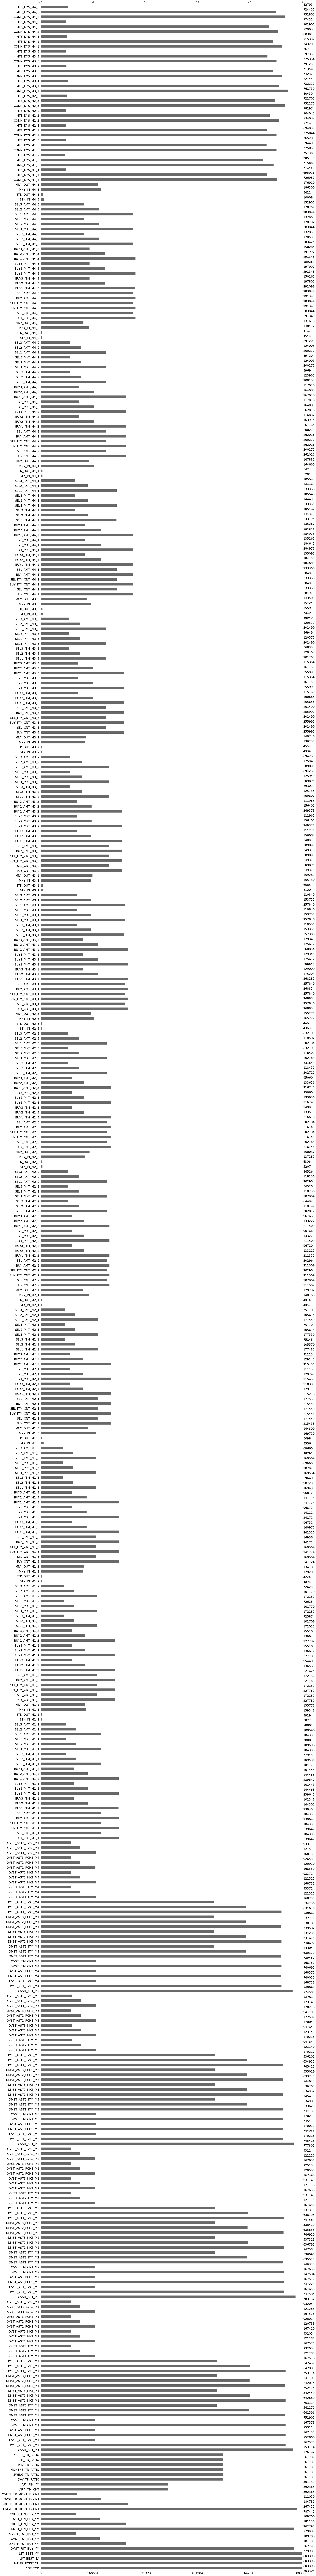

In [ ]:
msno.bar(cs_merge_data)
  # [참고] 데이터 상세상 0과 결측(NULL)의 구분이 없다는 점에서
  # 함부로 결측값을 예측모델로 대체하면 안됨

___

In [ ]:
market_index

BAS_DT           DOW        NASDAQ        SP500    KOSPI  KOSDAQ
0    20221201  34395.011719  11482.450195  4076.570068  2479.84  740.60
1    20221202  34429.878906  11461.500000  4071.699951  2434.33  732.95
2    20221205  33947.101562  11239.940430  3998.840088  2419.32  733.32
3    20221206  33596.339844  11014.889648  3941.260010  2393.16  719.44
4    20221207  33597.921875  10958.549805  3933.919922  2382.81  718.14
..        ...           ...           ...          ...      ...     ...
102  20230424  33875.398438  12037.200195  4137.040039  2523.50  855.23
103  20230425  33530.828125  11799.160156  4071.629883  2489.02  838.71
104  20230426  33301.871094  11854.349609  4055.989990  2484.83  830.44
105  20230427  33826.160156  12142.240234  4135.350098  2495.81  850.21
106  20230428  34098.160156  12226.580078  4169.479980  2501.53  842.83

[107 rows x 6 columns]

In [ ]:
class ExplolatoryDataAnalysis():

# Child 클래스내에 Parent 클래스의 메소드를 모두 가져오기
  def __init__(self, market_index_data: pd.DataFrame(), date_column: str,
               TimeSeries_method_return = None, Impute_method_return = None):

    self.market_index_data = market_index_data
    self.date_column = date_column
    self.TimeSeries_method_return = TimeSeries_method_return
    self.Impute_method_return = Impute_method_return
      # super().__init__(market_index)
      # super(파생클래스이름, self).__init__()
      # super(ClassName, self).__init__(**kwargs)


# timeSeriesPreprocessing()
  # 클래스 메소드의 큰 특징은, 첫 번째 인수로 객체가 넘어오는 게 아니라, 클래스가 넘어오게(@classmethod)
  # 1. 날짜형 타입 변환
  def timeSeriesPreprocessing(self):

    self.market_index_data[self.date_column] = self.market_index_data[self.date_column].astype("str")
    self.market_index_data[self.date_column] = self.market_index_data[self.date_column].apply(lambda x: datetime.datetime.strptime(x, "%Y%m%d"))

    if self.date_column in self.market_index_data.columns:
      # date_column(입력받은 날짜형 컬럼명)이 시장지수데이터의 컬럼 내 있다면
      self.market_index_data["DateTime"] = pd.to_datetime(self.market_index_data[self.date_column])
        # date_column을 DateTime이라는 날짜형 변수로 생성
    if self.market_index_data.index.dtype == "int64":
      # 인덱스 타입이 64비트 정수형이면, DateTime 컬럼으로 변경
      self.market_index_data.set_index("DateTime", inplace = True)
    self.market_index_data.drop([self.date_column], axis = 1, inplace = True)

    self.TimeSeries_method_return = self.market_index_data


# ImputeNotAvailableValue()
  # 2. 시계열 결측값 DOW(5) | NASDAQ(5) | SP500(5) | KOSPI(4) | KOSDAQ(4)
  def ImputeNotAvailableValue(self):

    KNN_NaN_Imputer = KNNImputer(n_neighbors = 5)
    self.market_index_data = pd.DataFrame(
        KNN_NaN_Imputer.fit_transform(self.market_index_data),
        index = self.market_index_data.index,
        columns = self.market_index_data.columns)

    self.Impute_method_return = self.market_index_data


# reviewNaN()
  # 3. 결측값이 K최근접 이웃 거리 기반 대체 시 어떻게 채워졌는지
  # 날짜와 시간의 간격을 2일로 두고 결측이었던 행 출력
  def reviewNaN(self):
    for col_name in self.TimeSeries_method_return.columns:
      nan_matrix = self.TimeSeries_method_return[col_name].isnull()
      print(self.TimeSeries_method_return[nan_matrix])


    for index in [
        "2022-12-26", "2022-12-30",
        "2023-01-02", "2023-01-16", "2023-01-23", "2023-01-24",
        "2023-02-20", "2023-03-01", "2023-04-07"]:
        index = str(index).replace("-","")
        before = datetime.datetime.strptime(index, "%Y%m%d") - relativedelta(days = 2)
        after = datetime.datetime.strptime(index, "%Y%m%d") + relativedelta(days = 3)

      # TypeError: unsupported operand type(s) for -: 'str' and 'datetime.timedelta'
      # datetime.datetime.strptime(index, "%Y%m%d")
        before = str(before).replace(" 00:00:00", "")
        after = str(after).replace(" 00:00:00", "")
        self.TimeSeries_method_return.index = self.TimeSeries_method_return.index.astype("str")

        print(
            self.TimeSeries_method_return.loc[before:after, :], "\n",
            self.Impute_method_return.loc[before:after, :], "\n")


# timeSeriesDecomposition()
  # 4. 시계열 분해 : 추세 + 계절성 + 잔차 or 추세 * 계절성 * 잔차
  def timeSeriesDecomposition(self, indice: str, decompose_method: str):
  # [decompose_method] additive, multicative
    decomposition = sm.tsa.seasonal_decompose(
        self.market_index_data[indice],
        model = decompose_method )

  # 4.1) 추세 : 시간에 따라 증감 또는 일정 수준을 유지하는 것(확률과정의 결정론적 기댓값 함수를 알아내는 것)
  # 확률과정 Y_t이 추정이 가능한 결정론적 추세함수 f(t)와 정상확률과정 Y_t^s의 합
  # Y_t = f(t) + Y_t^s
    indice_trend = pd.DataFrame(decomposition.trend)
    indice_trend.fillna(method = "ffill", inplace = True)
    indice_trend.fillna(method = "bfill", inplace = True)
    indice_trend.columns = ["TREND"]

  # 4.2) 계절성 : 일정한 빈도로 반복되는 패턴, 특정 월/요일에 따라 기댓값이 달라지는 것
    indice_seasonal = pd.DataFrame(decomposition.seasonal)
    indice_seasonal.fillna(method = "ffill", inplace = True)
    indice_seasonal.fillna(method = "bfill", inplace = True)
    indice_seasonal.columns = ["SEASONAL"]

    if "TREND" not in self.market_index_data.columns:
      if "SEASONAL" not in self.market_index_data.columns:
        self.market_index_data = pd.concat(
            [self.market_index_data, indice_trend, indice_seasonal], axis = 1 )

    return self.market_index_data

  # 4.3) 특정 시점을 기준으로 전후 12일씩 총 24일간의 이동평균된 pandas Series타입
  # Y_day = dataframe[[Y]].rolling(24).mean()
  # Y_week = dataframe[[Y]].rolling(24 * 7).mean()


# StationaryADFTest()
# 5. 시계열의 정상성(Stationarity) 검정 : 관측된 시간과 시계열의 특징은 무관할까
# Ha : 시계열에 단위근이 존재하지 않는다. (시계열이 정상성을 만족한다)
# https://www.statsmodels.org/dev/_modules/statsmodels/tsa/stattools.html#adfuller
  def StationaryADFTest(self, Y_data):

      stationary_adf = pd.Series(
        sm.tsa.stattools.adfuller(Y_data.values)[0:4],
        index = ["Test Statistics", "p-value", "Used Lag", "Used Observations"])
          # y_t = a_1*y_t-1 + a_2*y_t-2 + ... + e_t
          # [단위근(unit root)] t시점의 확률변수는 t-1, t-2, ... 시점의 확률변수와 관계가 있으며 에러가 포함되는 것
          # m**p - m**(p-1)*a_1 - m**(p-2)*a_2 - ... - a_p = 0
          # [m = 1] 위 식의 근이 되는 m = 1이면 시계열 확률 과정은 단위근을 가진다고 말한다.
          # 그렇지 않다면, 약정상성을 띠는 t시점 시계열 데이터는 확률 과정의 성질(E(Xt), Var(Xt))이 변하지 않는다.

      for key, value in sm.tsa.stattools.adfuller(Y_data.values)[4].items():
        stationary_adf["Critical Values(%s)"%key] = value
        stationary_adf["Maximum Information Criteria"] = sm.tsa.stattools.adfuller(Y_data.values)[5]
        stationary_adf = pd.DataFrame(
            stationary_adf, columns = ["stationarity_adf"])

      return stationary_adf


# AutoCorrelation
# 6. 시계열(시차)의 자기상관성 검정(Null Hypothesis: Autocorrelation is absent) : lag(시차) 1일, 5일, 10일, 50일
  def AutoCorrelation(self, Y_data):
    auto_correlation = pd.DataFrame(
        sm.stats.diagnostic.acorr_ljungbox(Y_data.values, lags = [1, 5, 10, 50])
    ).T
    auto_correlation.columns = [
        "자기상관(1일의 시차)", "자기상관(5일의 시차)", "자기상관(10일의 시차)", "자기상관(50일의 시차)"]
    auto_correlation.index = [
        "검정통계량", "유의확률(p-value)"]

    display(auto_correlation)


# timeSeriesDifferencing()
# 7. 정상성(stationarity)을 나타내지 않는 시계열의 정상성을 나타내도록, 추세나 계절성을 완화하는 차분
  # 시계열의 수준에서 나타나는 변화를 제거하여 시계열의 평균 변화를 일정하게 만드는데 도움이 된다.
  # 다시 말해 비정상적 시계열은 누적 과정(integrated procss)이기 때문에 발생할 수 있다.

  # [관측값의 차이, 차분] y_t = y_{t-1} + e_t
  # [2차 차분] ( y_t - y_{t-1} ) - ( y_{t-1} - y_{t-2} )
  # 2차 이상의 차분을 한 데이터로 적합한 모델의 설명력이 낮아질 수 있다.
  # [계절성 차분] y_t - y_{t-m} (단, m은 계절 수)
  def timeSeriesDifferencing(self, dataframe, indice):

    Y_differencing = dataframe[[indice]].diff()
    Y_differencing.fillna(method = "ffill", inplace = True)
    Y_differencing.fillna(method = "bfill", inplace = True)
    Y_differencing.columns = ["y_difference"]
    # if "y_difference" not in dataframe.columns: dataframe = pd.concat([dataframe, Y_differencing], axis = 1)
    return Y_differencing


# timeSeriesFinalData()
  def timeSeriesFinalData(self):

    Differencing_method_return = pd.DataFrame()
    self.market_index_data.info()
    for col_name in self.market_index_data.columns:
      Differencing_method_return[col_name] = self.timeSeriesDifferencing(
          dataframe = self.market_index_data, indice = col_name)

    return Differencing_method_return

In [ ]:
EDA = ExplolatoryDataAnalysis(
    market_index_data = market_index,
    date_column = "BAS_DT")
  # ValueError: This function does not handle missing values

In [ ]:
EDA.timeSeriesPreprocessing()

In [ ]:
EDA.ImputeNotAvailableValue()

In [ ]:
EDA.reviewNaN()

            DOW  NASDAQ  SP500    KOSPI  KOSDAQ
DateTime                                       
2022-12-26  NaN     NaN    NaN  2317.14  694.68
2023-01-02  NaN     NaN    NaN  2225.67  671.51
2023-01-16  NaN     NaN    NaN  2399.86  716.89
2023-02-20  NaN     NaN    NaN  2455.12  788.89
2023-04-07  NaN     NaN    NaN  2490.41  880.07
            DOW  NASDAQ  SP500    KOSPI  KOSDAQ
DateTime                                       
2022-12-26  NaN     NaN    NaN  2317.14  694.68
2023-01-02  NaN     NaN    NaN  2225.67  671.51
2023-01-16  NaN     NaN    NaN  2399.86  716.89
2023-02-20  NaN     NaN    NaN  2455.12  788.89
2023-04-07  NaN     NaN    NaN  2490.41  880.07
            DOW  NASDAQ  SP500    KOSPI  KOSDAQ
DateTime                                       
2022-12-26  NaN     NaN    NaN  2317.14  694.68
2023-01-02  NaN     NaN    NaN  2225.67  671.51
2023-01-16  NaN     NaN    NaN  2399.86  716.89
2023-02-20  NaN     NaN    NaN  2455.12  788.89
2023-04-07  NaN     NaN    NaN  2490.41 

In [ ]:
DOW_EDA = EDA.timeSeriesDecomposition(
    indice = "DOW", decompose_method = "multicative")
NASDAQ_EDA = EDA.timeSeriesDecomposition(
    indice = "NASDAQ", decompose_method = "multicative")
SP500_EDA = EDA.timeSeriesDecomposition(
    indice = "SP500", decompose_method = "multicative")
KOSPI_EDA = EDA.timeSeriesDecomposition(
    indice = "KOSPI", decompose_method = "multicative")
KOSDAQ_EDA = EDA.timeSeriesDecomposition(
    indice = "KOSDAQ", decompose_method = "multicative")

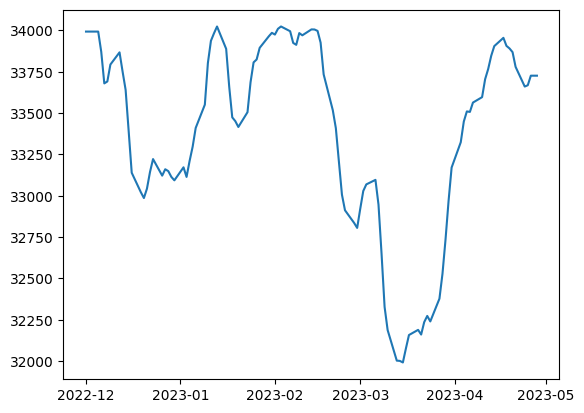

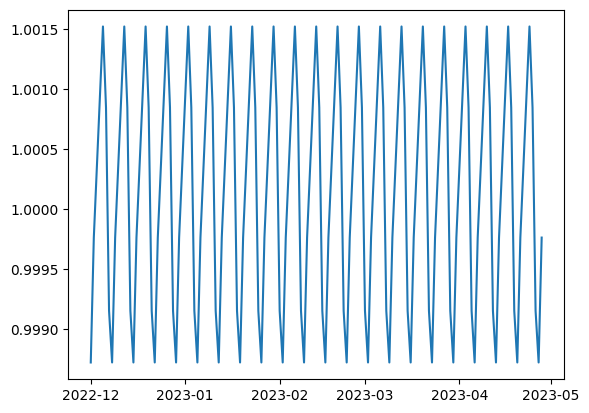

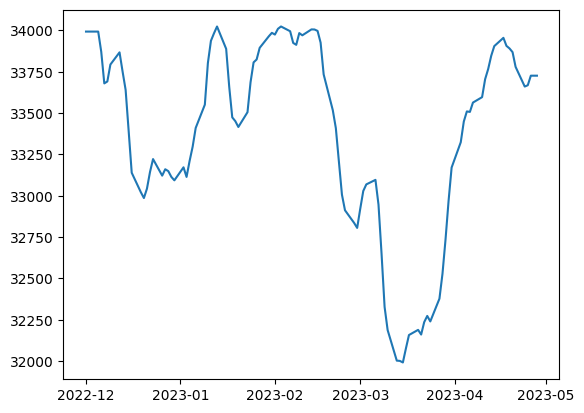

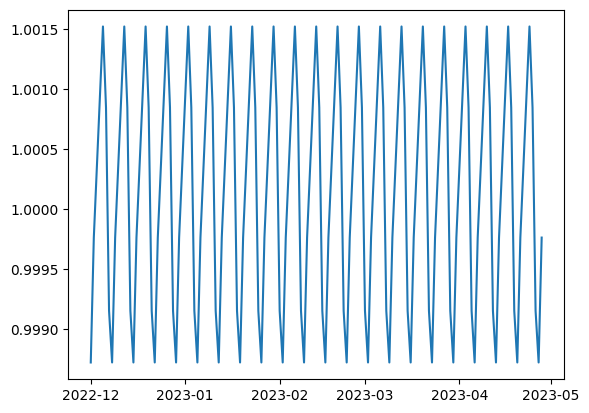

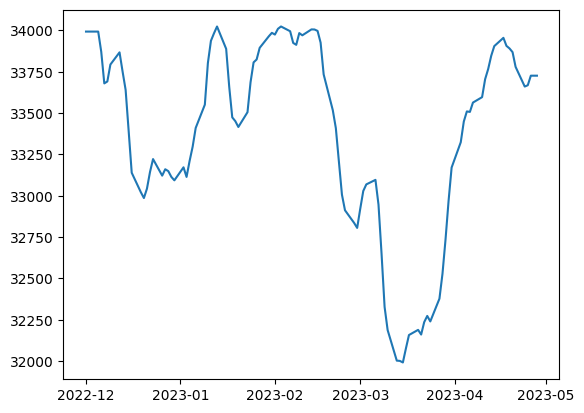

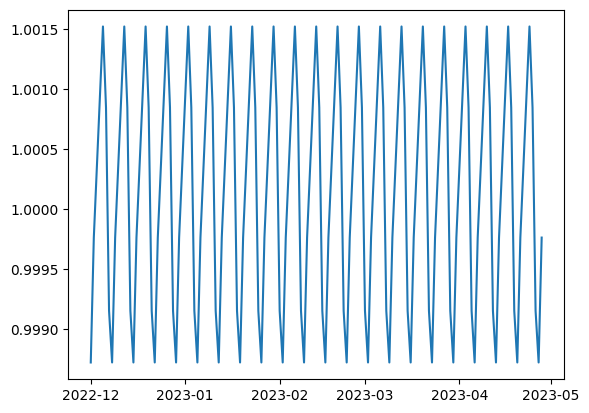

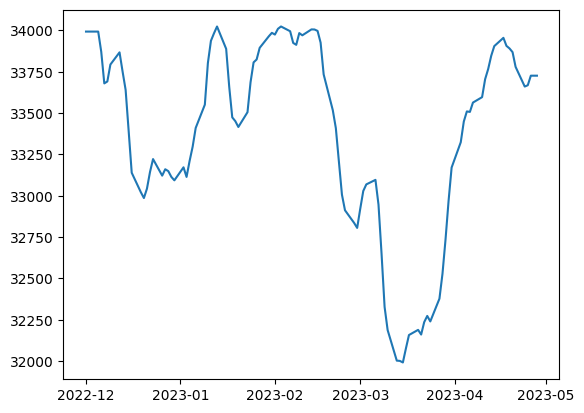

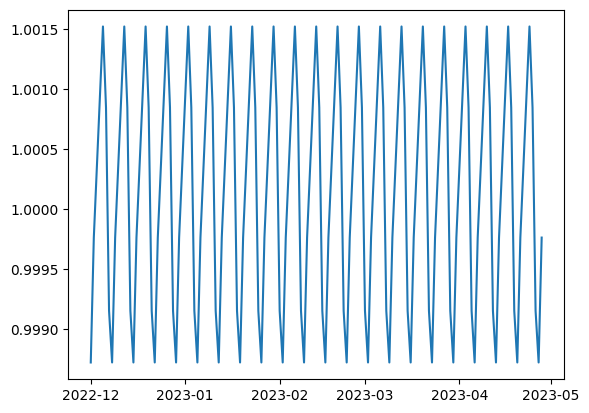

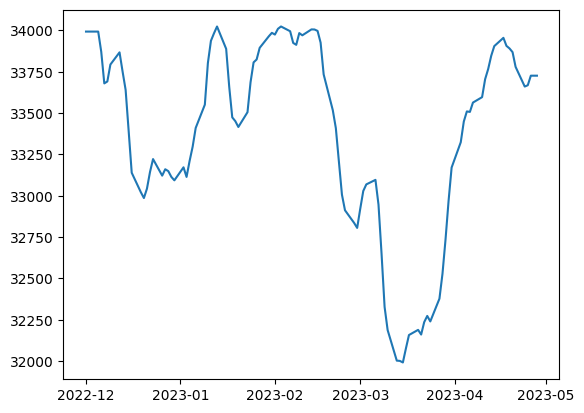

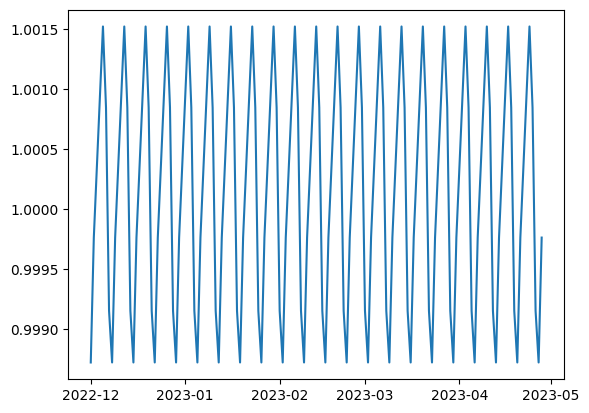

In [ ]:
market_index_decomposition = pd.DataFrame()
for indice in [DOW_EDA, NASDAQ_EDA, SP500_EDA, KOSPI_EDA, KOSDAQ_EDA]:
  market_index_decomposition = pd.concat(
      [market_index_decomposition, indice[["TREND", "SEASONAL"]]], axis = 1)
# market_index_decomposition = pd.concat([market_index, market_index_decomposition], axis = 1)

for indice in [DOW_EDA, NASDAQ_EDA, SP500_EDA, KOSPI_EDA, KOSDAQ_EDA]:
  plt.plot(indice["TREND"])
  plt.show()
  plt.plot(indice["SEASONAL"])
  plt.show()

In [ ]:
# 단위근 검정(정상성)
for col_name in market_index.columns:
  print(
      col_name, "\n",
      EDA.StationaryADFTest(Y_data = DOW_EDA[col_name]), "\n")

# 자기상관 검정(시간의 흐름에 따라 독립적이지 않다)
for col_name in market_index.columns:
  print(
      col_name, "\n",
      EDA.AutoCorrelation(Y_data = DOW_EDA[col_name]), "\n")

DOW 
                               stationarity_adf
Test Statistics                      -2.523928
p-value                               0.109760
Used Lag                              0.000000
Used Observations                   106.000000
Critical Values(1%)                  -3.493602
Maximum Information Criteria       1312.613191 

NASDAQ 
                               stationarity_adf
Test Statistics                      -1.046685
p-value                               0.735859
Used Lag                              0.000000
Used Observations                   106.000000
Critical Values(1%)                  -3.493602
Maximum Information Criteria       1197.032120 

SP500 
                               stationarity_adf
Test Statistics                      -1.779301
p-value                               0.390785
Used Lag                              0.000000
Used Observations                   106.000000
Critical Values(1%)                  -3.493602
Maximum Information Criteria     

자기상관(1일의 시차)  자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량          8.527534e+01  2.876031e+02   3.948689e+02   7.810280e+02
유의확률(p-value)  2.595807e-20  4.627228e-60   1.163120e-78  6.854429e-132

DOW 
 None 



자기상관(1일의 시차)  자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량          1.001916e+02  4.369366e+02   7.409639e+02   9.254547e+02
유의확률(p-value)  1.383479e-23  3.227346e-92  1.002960e-152  1.730735e-161

NASDAQ 
 None 



자기상관(1일의 시차)  자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량          9.108332e+01  3.464012e+02   5.197851e+02   9.490307e+02
유의확률(p-value)  1.377481e-21  1.042050e-72  2.604801e-105  2.401035e-166

SP500 
 None 



자기상관(1일의 시차)  자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량          9.805827e+01  4.083167e+02   6.034794e+02   7.295636e+02
유의확률(p-value)  4.062508e-23  4.782546e-86  3.163751e-123  2.008363e-121

KOSPI 
 None 



자기상관(1일의 시차)   자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량          1.059092e+02   4.938633e+02   8.639930e+02   1.352605e+03
유의확률(p-value)  7.719255e-25  1.685838e-104  3.564918e-179  2.703653e-250

KOSDAQ 
 None 



___

In [ ]:
differencing_market_index = EDA.timeSeriesFinalData()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 107 entries, 2022-12-01 to 2023-04-28
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DOW       107 non-null    float64
 1   NASDAQ    107 non-null    float64
 2   SP500     107 non-null    float64
 3   KOSPI     107 non-null    float64
 4   KOSDAQ    107 non-null    float64
 5   TREND     107 non-null    float64
 6   SEASONAL  107 non-null    float64
dtypes: float64(7)
memory usage: 10.8 KB


In [ ]:
# 1차 차분 데이터
differencing_market_index.drop(["TREND", "SEASONAL"], axis = 1, inplace = True)

In [ ]:
# 단위근 검정(정상성)
for col_name in differencing_market_index.columns:
  print(
      col_name, "\n",
      EDA.StationaryADFTest(Y_data = differencing_market_index[col_name]), "\n")

# 자기상관 검정(시차의 독립성)
for col_name in market_index.columns:
  print(
      col_name, "\n",
      EDA.AutoCorrelation(Y_data = differencing_market_index[col_name]), "\n")

DOW 
                               stationarity_adf
Test Statistics                  -1.089691e+01
p-value                           1.185859e-19
Used Lag                          0.000000e+00
Used Observations                 1.060000e+02
Critical Values(1%)              -3.493602e+00
Maximum Information Criteria      1.315132e+03 

NASDAQ 
                               stationarity_adf
Test Statistics                  -8.213004e+00
p-value                           6.739335e-13
Used Lag                          1.000000e+00
Used Observations                 1.050000e+02
Critical Values(1%)              -3.494220e+00
Maximum Information Criteria      1.197035e+03 

SP500 
                               stationarity_adf
Test Statistics                  -7.982464e+00
p-value                           2.601282e-12
Used Lag                          1.000000e+00
Used Observations                 1.050000e+02
Critical Values(1%)              -3.494220e+00
Maximum Information Criteria     

자기상관(1일의 시차)  자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량              0.536097      2.403366       5.921945      40.319606
유의확률(p-value)      0.464055      0.790973       0.821778       0.834179

DOW 
 None 



자기상관(1일의 시차)  자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량              0.033592      6.431281      16.951338      70.084841
유의확률(p-value)      0.854576      0.266485       0.075448       0.031885

NASDAQ 
 None 



자기상관(1일의 시차)  자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량              0.094647      5.694279      13.707100      61.515680
유의확률(p-value)      0.758350      0.337112       0.186776       0.127361

SP500 
 None 



자기상관(1일의 시차)  자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량              0.279389      5.043735      10.833294      54.687297
유의확률(p-value)      0.597102      0.410566       0.370653       0.301162

KOSPI 
 None 



자기상관(1일의 시차)  자기상관(5일의 시차)  자기상관(10일의 시차)  자기상관(50일의 시차)
검정통계량              0.768221      8.045546      10.888326      49.794678
유의확률(p-value)      0.380768      0.153743       0.366284       0.481579

KOSDAQ 
 None 



In [ ]:
differencing_market_index.isnull().sum()
# 재현성을 위한 데이터 csv 파일 저장
# differencing_market_index.to_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/difference_market_index.csv", index = True)

___

### 1.OPEN DART API를 활용한 상장회사의 재무제표 주요 계정과목 데이터를 수집하는 클래스(추가 오픈소스 활용)
* 단, AfterLearnerProject > DataArchive > DART_2022_2021_1Q 파일 내 저장된 1분기 데이터 활용
* API 설명서 : https://opendart.fss.or.kr/guide/detail.do?apiGrpCd=DS003&apiId=2019016


In [ ]:
class OpenDartDataCrawling():

  def __init__(self, api_key: str):
    self.api_key = api_key
      # certification key는 open dart api key를 나타내는 명칭


# getStockCode()
# 상장주식회사의 고유번호, 회사명, 종목코드, 수정일을 반환하는 메서드
  def getStockCode(self, url: str) -> Any:
    parameters = {"crtfc_key": self.api_key}
    items = ["corp_code", "corp_name", "stock_code", "modify_date"]
    item_names = ["고유번호", "회사명", "종목코드", "수정일"]

    response_url = requests.get(url, params = parameters)
    zfile = zipfile.ZipFile(io.BytesIO(response_url.content))
      # url 입력변수로 json경로를 통해 요청하여 받은 응답값은 zip파일로 받음
    open_zip_file = zfile.open(zfile.namelist()[0])
      # 받은 zip파일의 압축을 풀어 open_zip_file에 저장
    decoding_root = ETREE.fromstring(open_zip_file.read().decode("utf-8"))
      # "utf-8"으로 유니코드 인코딩(코드화/암호화/부호화)된 open_zip_file을 이해할 수 있도록 디코딩(복호화) 수행

    stockcode_list: List = []
    for child in decoding_root:
      if len(child.find("stock_code").text.strip()) > 1:
        # 종목코드가 있는 경우에는(공백 제거 후 텍스트 길이가 1 초과하는 경우)
        stockcode_list.append([])
        # 종목번호 리스트에 추가
        for item in items:
          stockcode_list[-1].append(child.find(item).text)
            # 종목번호 리스트 맨 마지막 인덱스에 item(종목코드)에 해당하는 고유번호, 회사명, 수정일 txt 데이터를 찾아 리스트에 원소로 추가

    stockcode_data = pd.DataFrame(stockcode_list, columns = item_names)
      # 각 종목번호 리스트를 데이터프레임의 컬럼으로 하여 종목 데이터 생성
    return stockcode_data
      # 종목번호 데이터 반환


# requestData()
# open Dart API인증키 등 요청인자를 통해 json으로 url을 요청하고 응답키를 받아오는 메서드
  def requestData(self, url: str, items: List, item_names: List, params: Dict) -> Any:
    response_url = requests.get(url, params = params)
    json_data = response_url.json()
      # json으로 url 요청
    json_dictionary = json.loads(response_url.text)
      #

    data: List = []
    if json_dictionary["status"] == "000":
      # 딕셔너리 키에 대한 값이 정상적으로 있다면
      # 응답키 status는 에러 및 정보 코드를 나타낸다.
      for line in json_dictionary["list"]:
        data.append([])
        for item in items:
          # [item] 반환되는 데이터들의 key를 가진 리스트
          if item in line.keys():
            data[-1].append(line[item])
          else:
            data[-1].append("")
    items_data = pd.DataFrame(data, columns = item_names)
    return items_data


# getSingleFinancialSheet()
# 단일상장주식회사의 재무제표(재무상태표, [포괄]손익계산서, 현금흐름표, 자본변동표) 주요계정과목 데이터를 불러오는 메서드
  def getSingleFinancialSheet(self,
                              url: str, items: List, item_names: List,
                              stock_code: str, business_year, report_code: str, YN: str) -> Any:
    parameters = {
        "crtfc_key":self.api_key,
        "corp_code":stock_code,
        "bsns_year":business_year,
        "reprt_code":report_code,
        "fs_div":YN}
    single_items_data = self.requestData(url = url, items = items, item_names = item_names, params = parameters)
      # AttributeError: 'str' object has no attribute 'read'
    return single_items_data


In [ ]:
def main():

  # OpenDartDataCrawling()클래스의 인스턴스 loadData 선언
  loadData = OpenDartDataCrawling(api_key = "148723a5dc441466805520cde2aef20fd64cc5e7")

  # 상장회사 종목코드를 불러오는 getStockCode() 메서드를 통해 stock_code_dict 변수와 결합하여 저장
  stock_code_dict = loadData.getStockCode(url = "https://opendart.fss.or.kr/api/corpCode.xml")

  # 재무상태표(BS), 포괄손익계산서(CIS), 현금흐름표(CF), 자본변동표(SCE), 손익계산서(IS) 데이터프레임을
  # 인덱스로 하는 데이터프레임의 데이터프레임을 생성(이중 리스트와 유사한 방식)
  final_report_data = pd.DataFrame()

  for k in tqdm(range(1, len(stock_code_dict))):
    report_data = loadData.getSingleFinancialSheet(
        # JSON출력 포멧의 요청(GET) URL
        url = "https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json?",
        # 응답값에 대한 규정된 응답키
        items = [
            "rcept_no","reprt_code","bsns_year","corp_code","sj_div","sj_nm",
            "account_id","account_nm","account_detail","thstrm_nm", "thstrm_amount",
            "thstrm_add_amount","frmtrm_nm","frmtrm_amount", "frmtrm_q_nm","frmtrm_q_amount",
            "frmtrm_add_amount","bfefrmtrm_nm", "bfefrmtrm_amount","ord"],
        # 응답키 이름 리스트
        item_names = [
            "접수번호","보고서코드","사업연도","고유번호","재무제표구분", "재무제표명",
            "계정ID","계정명","계정상세","당기명","당기금액", "당기누적금액","전기명","전기금액","전기명(분/반기)",
            "전기금액(분/반기)","전기누적금액","전전기명","전전기금액", "계정과목정렬순서"],
        # 딕셔너
        stock_code = stock_code_dict.iloc[k, 0],
        # 사업연도
        business_year = 2022,
        # [1분기] 11013
        # [반기] 11012
        # [3분기] 11014
        # [연간] 사업보고서 11011
        report_code = "11011",
        # 개별(OFS)/연결(CFS) 재무제표 여부
        YN = "CFS")
    final_report_data = pd.concat([final_report_data, report_data], axis = 0)

    def seperateFinancialSheet(sheet_name: str, crawling_data: pd.DataFrame) -> Any:
      seperated_data = crawling_data[crawling_data["재무제표구분"] == sheet_name]
      return seperated_data

    BalanceSheet = seperateFinancialSheet("BS", final_report_data)
    ComprehensiveIncomeSheet = seperateFinancialSheet("CIS", final_report_data)
    CashFlowSheet = seperateFinancialSheet("CF", final_report_data)
    StatementofChanges = seperateFinancialSheet("SCE", final_report_data)
    IncomeSheet = seperateFinancialSheet("IS", final_report_data)

    BalanceSheet.to_csv("/content/drive/MyDrive/BalanceSheet2022.csv", index = False)
    ComprehensiveIncomeSheet.to_csv("/content/drive/MyDrive/ComprehensiveIncomeSheet2022.csv", index = False)
    CashFlowSheet.to_csv("/content/drive/MyDrive/CashFlowSheet2022.csv", index = False)
    StatementofChanges.to_csv("/content/drive/MyDrive/StatementofChanges2022.csv", index = False)
    IncomeSheet.to_csv("/content/drive/MyDrive/IncomeSheet2022.csv", index = False)


In [ ]:
if __name__ == "__main__" :
    main()

### 2.결측값 대체 및 시계열 전처리(차분) 완료된 Dow, NASDAQ, S&P500, KOSPI, KOSDAQ 지수 선형결합(5차원 축소)

* https://towardsdatascience.com/a-step-by-step-implementation-of-principal-component-analysis-5520cc6cd598

* https://datascienceschool.net/02%20mathematics/03.03%20%EA%B3%A0%EC%9C%B3%EA%B0%92%20%EB%B6%84%ED%95%B4.html

* https://excelsior-cjh.tistory.com/167

* PCA를 사용하여 이상값을 감지할 수도 있습니다. k개의 구성 요소를 사용하여 데이터를 재구성할 때 k≤n(여기서 n은 원래 차원) 이상값은 더 높은 재구성 손실을 제공합니다. 이상값과 비이상값에 대한 재구성 손실의 히스토그램을 계산할 수 있습니다. 그런 다음 이상치를 버릴 임계값을 선택합니다.


In [ ]:
class PrincipalComponentAnalysis():

  def __init__(self, file_path: str):
    self.differencing_market_index = pd.read_csv(file_path, index_col = 0)


# linearCombinationPCA()
  def linearCombinationPCA(self, k: int):
  # 1. 표준화
    mean_matrix = self.differencing_market_index.mean()
    std_matrix = self.differencing_market_index.std()
    substract_mean_matrix = (self.differencing_market_index - mean_matrix)
    normalized_matrix = (self.differencing_market_index - mean_matrix) / std_matrix

  # 2. 공분산 행렬(Calculate the Covariance Matrix of the mean-centered data.)
    covariance_matrix = np.cov(substract_mean_matrix.T)
    # 공분산 행렬의 고유 분해(고유값과 고유벡터를 찾는 작업)를 수행하여 고유벡터(분산방향)와 고유값
    # 행렬 A의 고유값은 A−λI의 행렬식이 0이 되도록 하는 특성방정식(characteristic equation)의 해를 구하면 된다.
    # 고윳값을 알면 다음 연립 방정식을 풀어 고유벡터를 구할 수 있다. (A−λI)v=0
    eigen_values, eigen_vectors = np.linalg.eigh(covariance_matrix)

  # 3. 고윳값과 고유벡터를 내림차순 정렬(모든 고유벡터는 서로 직교함)
  # numpy.linalg.eigh( M, UPLO = 'L'/'U'/'None'(optional))
  # [M] Matrix, M행렬은 본질적으로 실제 대칭인 입력
  # [UPLO] 행렬의 고유값이 계산되는 위(U) 또는 아래(L) 삼각형 부분
    sorted_index = np.arange(0, len(eigen_values), 1)
    sorted_index = ([x for _, x
                     in sorted(zip(eigen_values, sorted_index))])[::-1]
    # 동일한 기능을 하는 소스코드
    # sorted_index = np.argsort(eigen_values)[::-1]
      # [np.argsort] returns an array of indices of the same shape.

    sorted_eigen_values = eigen_values[sorted_index]
    sorted_eigen_vectors = eigen_vectors[:, sorted_index]
    print("내림차순 정렬한 고유값",  "\n", sorted_eigen_values,
          "\n", "내림차순 정렬한 고유벡터",  "\n", sorted_eigen_vectors)

  # 4. 원하는 결합정도에 따라 상위 k의 고유벡터를 선택하는데 모든 고유값의 누적합계로  설명된 분산 기여율 계산
    sum_eigen_values = np.sum(sorted_eigen_values)
    explained_variance = sorted_eigen_values / sum_eigen_values
    cummulative_variance = np.cumsum(explained_variance)
    print("누적 분산 기여율", "\n", cummulative_variance, "\n")
      # [0.92443721 0.9931338  0.99939027 0.99976834 1.        ]

  # 5. 변환된 데이터로 고유벡터의 전치행렬의 내적을 취하여 원본 데이터를 결합(데이터를 중앙에 배치하기 위해 평균을 뺌)
    n_components = k
      # k = 1
    eigen_vectors_subset = sorted_eigen_vectors[:, 0:n_components]

  # 6. 고유벡터를 사용하여 데이터의 좌표방향변환(회전) -> 정사영 / 투영 / 내적
  # PC(주성분 공간에서의 좌표) = Z(표준화된 원래의 좌표)*A(좌표변환행렬) = [z_x, z_y]([a_1, a_2]).T = a_1*z_x + a_2*z_y
  # A(시계방향 45도 회전행렬, Rotation Matrix) = [(cos(45), -sin(45)), (sin(45), cos(45))] = [(0.71, -0.71), (0.71, 0.71)]
    pca_matrix = np.dot(substract_mean_matrix, eigen_vectors_subset)
    # print("좌표변환한 행렬", "\n", pca_matrix, "\n")

    reduction_matrix = pd.Series(np.array(pca_matrix, ndmin = 1).tolist())
    for parenthesis in ["[", "]"]:
      reduction_matrix = reduction_matrix.apply(lambda data: str(data).replace(parenthesis, ""))
    reduction_matrix = reduction_matrix.astype("float")
    reduction_matrix.index = self.differencing_market_index.index
    return reduction_matrix

    # 에러코드
      # ValueError: shapes (5,1) and (5,) not aligned: 1 (dim 1) != 5 (dim 0)
      # k_reduction_matrix  = np.dot(eigen_vectors_subset, mean_matrix.transpose()).transpose()


# SklearnlinearPCA()
# Scikit-Learn 모듈을 활용한 주성분과 결과가 같은지 비교
  def SklearnlinearPCA(self, k: int):

    from sklearn.decomposition import PCA

    sklearn_pca= PCA(n_components = k)
    self.scaled_market_index = self.differencing_market_index.apply(
        lambda data: data - data.mean() / data.std())

    sklearn_pca.fit(self.scaled_market_index)
    sklearn_pca_matrix = sklearn_pca.transform(self.scaled_market_index)
    return sklearn_pca_matrix


# sparsePCA() 희소주성분분석
  def SklearnSparsePCA(self, k: int, c: float):

    from sklearn.decomposition import SparsePCA
    # L1 정규화는 가중치 벡터의 절댓값 합을 최소화
    # L1 정규화를 PCA에 적용함으로써, 주성분 벡터의 일부 요소는 0으로 만들어지고, 다른 요소들은 비교적 큰 값을 가지게 된다.
    # L1 정규화의 강도를 조절하는 하이퍼파라미터
    sklearn_sparse_pca= SparsePCA(n_components = k, alpha = c , random_state = 2023)
    self.scaled_market_index = self.differencing_market_index.apply(
        lambda data: data - data.mean() / data.std())

    sklearn_sparse_pca.fit(self.scaled_market_index)
    sklearn_sparse_pca_matrix = sklearn_sparse_pca.transform(self.scaled_market_index)

    sparse_pca_matrix = pd.Series(np.array(sklearn_sparse_pca_matrix, ndmin = 1).tolist())
    for parenthesis in ["[", "]"]:
      sparse_pca_matrix = sparse_pca_matrix.apply(lambda data: str(data).replace(parenthesis, ""))
    sparse_pca_matrix = sparse_pca_matrix.astype("float")
    sparse_pca_matrix.index = self.differencing_market_index.index
    return sparse_pca_matrix


In [ ]:
PCAinstance = PrincipalComponentAnalysis(
    file_path =  "/content/drive/MyDrive/AfterLearnerProject/DataArchive/difference_market_index.csv")

In [ ]:
marketIndex_linearPCA = PCAinstance.linearCombinationPCA(k = 1)

내림차순 정렬한 고유값 
 [9.20476948e+04 6.84022974e+03 6.22966824e+02 3.76451373e+01
 2.30663735e+01] 
 내림차순 정렬한 고유벡터 
 [[-0.8998291  -0.43084114 -0.0182263  -0.00772164 -0.06551086]
 [-0.41793594  0.89395214  0.05390466 -0.01660365 -0.15165001]
 [-0.1248949   0.109946   -0.00112781  0.09879185  0.98109737]
 [-0.00514909  0.05265622 -0.94278174 -0.32820393  0.02540845]
 [-0.00344826  0.01909643 -0.328517    0.93924813 -0.09753447]]
누적 분산 기여율 
 [0.92443721 0.9931338  0.99939027 0.99976834 1.        ] 



In [ ]:
marketIndex_sklearnPCA = PCAinstance.SklearnlinearPCA(k = 1)
marketIndex_sklearnPCA[0:10]

array([[  -4.03837601],
       [  -4.03837601],
       [ 553.90197515],
       [ 434.76775907],
       [  40.80873039],
       [-202.67018315],
       [ 328.03830456],
       [-522.98135372],
       [-126.39788606],
       [ 184.50888506]])

In [ ]:
marketIndex_linearPCA

DateTime
2022-12-01     -4.038376
2022-12-02     -4.038376
2022-12-05    553.901975
2022-12-06    434.767759
2022-12-07     40.808730
                 ...    
2023-04-24    -27.619900
2023-04-25    435.655110
2023-04-26    202.671306
2023-04-27   -584.415449
2023-04-28   -266.557493
Length: 107, dtype: float64

In [ ]:
marketIndex_sklearnSparsePCA = PCAinstance.SklearnSparsePCA(k = 1, c = 0.1)
marketIndex_sklearnSparsePCA

DateTime
2022-12-01     -4.000982
2022-12-02     -4.000982
2022-12-05    548.417238
2022-12-06    430.460748
2022-12-07     40.403203
                 ...    
2023-04-24    -27.348737
2023-04-25    431.338517
2023-04-26    200.666863
2023-04-27   -578.627679
2023-04-28   -263.919242
Length: 107, dtype: float64

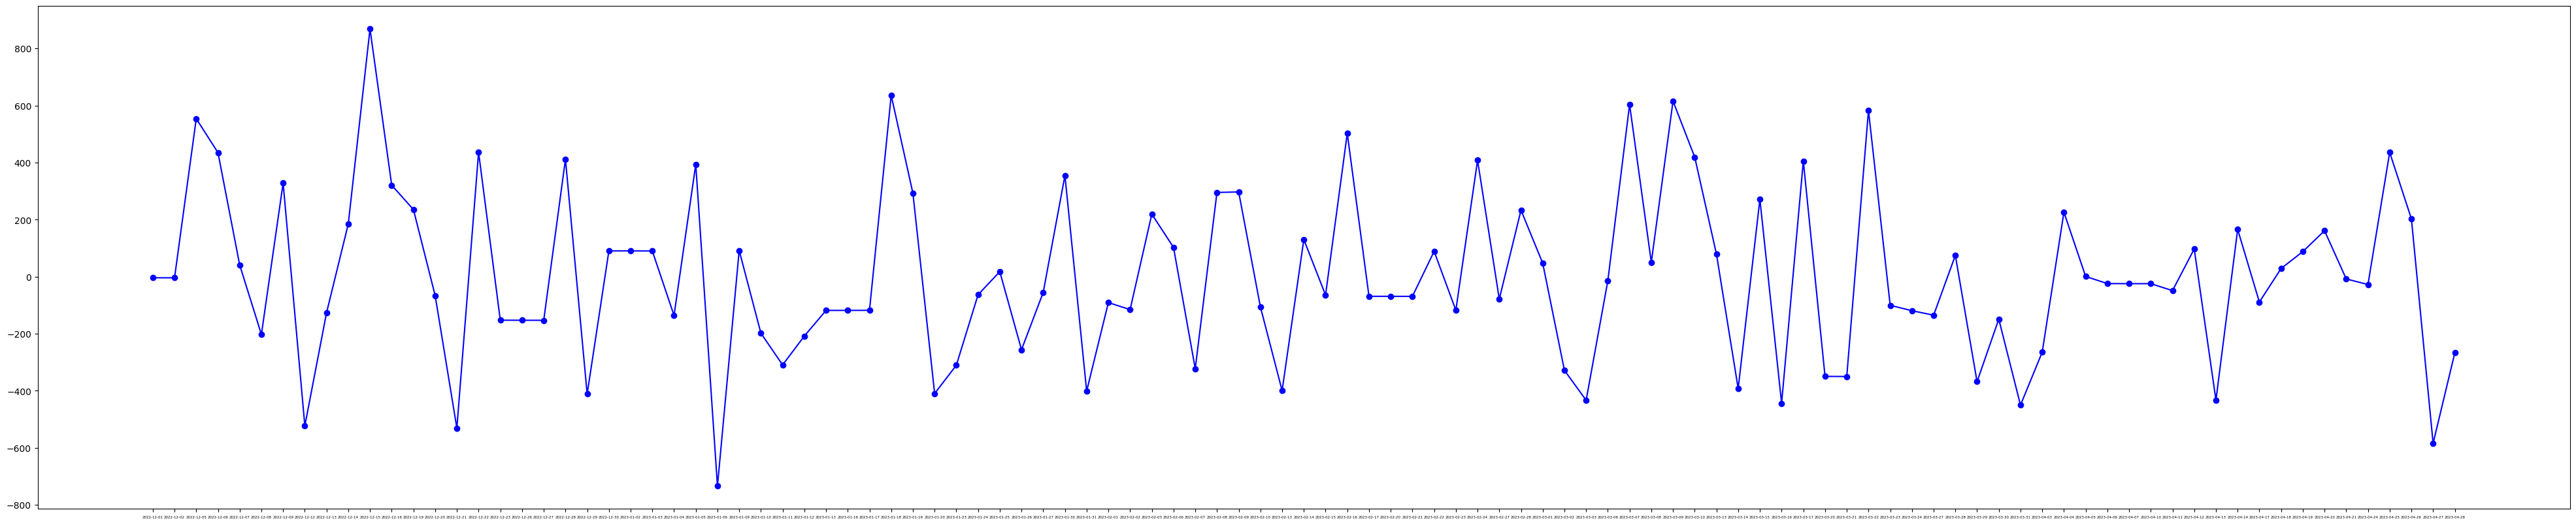

In [ ]:
fig = plt.figure(figsize = (50, 10))
plt.xticks(fontsize = 4)
# plt.rc("axes", labelsize = 3)
plt.plot(
    marketIndex_linearPCA.index,
    marketIndex_linearPCA.values,
    color = "blue", marker = "o", )
  # roll_mean5.plot

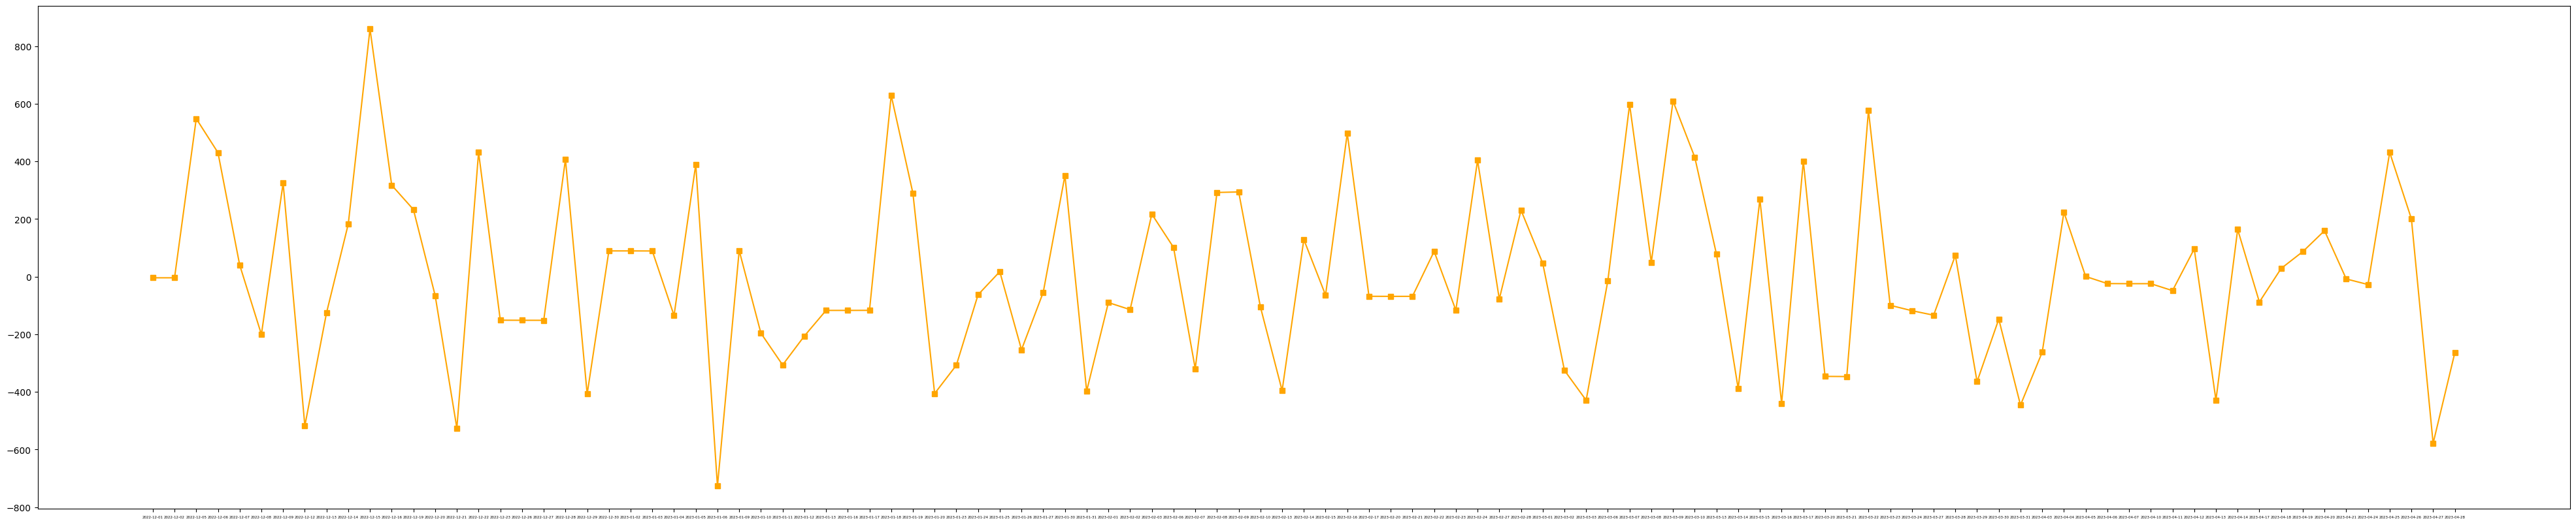

In [ ]:
fig = plt.figure(figsize = (50, 10))
plt.xticks(fontsize = 4)
plt.plot(
    marketIndex_sklearnSparsePCA.index,
    marketIndex_sklearnSparsePCA.values,
    color = "orange", marker = "s")

### 3.AI뉴스데이터와 선형결합주가지수 데이터 병합하여 사건이라고 관측되는 특정 시점 찾기

* 데이터 시계열 : 2022-12-01 ~ 2023-06-30

```
    class SearchEventPattern():

      def __init__(self,
                  news_202301_path: str, news_202302_path: str,
                  news_202303_path: str, news_202304_path: str,
                  news_202305_path: str, news_202306_path: str):

        self.news_202301_data = pd.read_excel(news_202301_path, index_col = False)
        self.news_202302_data = pd.read_excel(news_202302_path, index_col = False)
        self.news_202303_data = pd.read_excel(news_202303_path, index_col = False)
        self.news_202304_data = pd.read_excel(news_202304_path, index_col = False)
        self.news_202305_data = pd.read_excel(news_202305_path, index_col = False)
        self.news_202306_data = pd.read_excel(news_202306_path, index_col = False)


      def loadAINewsData(self):
        return self.news_202301_data, self.news_202302_data, self.news_202303_data, self.news_202304_data, self.news_202305_data, self.news_202306_data

    # 런타임 에러 -> 강제 종료/

    PointofView = SearchEventPattern(
        news_202301_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/news_dataset_202301/2023BigFesta_NewsDataset_202301_5.xlsx",
        news_202302_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/news_dataset_202302/2023BigFesta_NewsDataset_202302_5.xlsx",
        news_202303_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/news_dataset_202303/2023BigFesta_NewsDataset_202303_5.xlsx",
        news_202304_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/news_dataset_202304/2023BigFesta_NewsDataset_202304_5.xlsx",
        news_202305_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/news_dataset_202305/2023BigFesta_NewsDataset_202305_5.xlsx",
        news_202306_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/news_dataset_202306/2023BigFesta_NewsDataset_202306_5.xlsx"
    )

    # news_202301_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/news_dataset_202301/2023BigFesta_NewsDataset_202301_5.xlsx"
    # news_202301 = pd.read_excel(news_202301_path, index_col = False)
```

In [ ]:
# AI뉴스데이터(2023-01-01 ~ 2023-06-30) 병합하는 소스코드
# -> 이미 실행하여 저장하였으므로 다시 실행하지 않음

"""
class SearchEventPattern():

    def __init__(self, news_data_path):
        self.AInews_data = pd.read_excel(news_data_path, index_col = False)

    def loadAInewsData(self):
      return self.AInews_data


AInews_data = pd.DataFrame()

for date_time1 in range(202301, 202305, 1):
    # date_time2 = str(date_time1).replace("0", "_0")
    PointofView = SearchEventPattern(
        news_data_path = f"/content/drive/MyDrive/AfterLearnerProject/DataArchive/news_dataset_{date_time1}/2023BigFesta_NewsDataset_{date_time1}_5.xlsx")

    AInews_datetime = PointofView.loadAInewsData()
    AInews_data = pd.concat([AInews_data, AInews_datetime], axis = 0)

    time.sleep(1)

AInews_data.drop(["Unnamed: 0", "WRITER", "CONTENT"], axis = 1, inplace = True)
AInews_data.to_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/AInews_data.csv", index = False)
"""

    # 1.
    # str(date_time2).replace("_", "")
    # 일단 string에 _있는 버전으로 date_time2 설정 후
    # 공백처리하여 date_time1 설정

    # 2.
    # 아니면 202301을 정수형으로 설정한 후 date_time += 1을 통해 설정
    # date_time1에서 4자리 수 뒤에 "_" 추가하는 방식으로 date_time2 생성

    # 3.
    # 문제는 DATE_TIME 컬럼이 YYYYMMDD_HHmmSS형식이라는 점
    # 6개의 xlsx 확장자 데이터(파일 크기를 고려할 때)를 어떻게 메모리 공간에
    # 부담이 가지 않도록 병합하여 활용할지가 관건


In [ ]:
class SearchEventPattern():

  def __init__(self,
               news_data_path: str, index_news_data = None):

    self.AInews_data = pd.read_csv(news_data_path, index_col = False, encoding = "utf-8", na_values = "NaN")
      # [DATE_TIME] 뉴스수신시각
      # [WRITER] 뉴스제공자
      # [SUBCATEGORY] 정치/경제/사회/기술
      # [TITLE] 뉴스제목
      # [MAIN][IMPORTANCE] 뉴스중요도(0~100사이 주가영향력 주제분류모델 스코어)
      # [ITEM_NAME] 뉴스연관종목명
      # [TAG_LIST] 뉴스 관련 태그(regex활용하여 태그 내 값 분리할 것) # [CONTENT] html
    self.index_news_data = index_news_data


  def cleaningNewsData(self):

    # 날짜와 시간 형식의 문자열을 datetime으로 변환
    # datetime.strptime(문자열, 형식)
    self.AInews_data["YYYYMMDD"] = self.AInews_data["DATE_TIME"].apply(
        lambda time: datetime.datetime.strptime(time[0:8], "%Y%m%d") )
    self.AInews_data["HHmmSS"] = self.AInews_data["DATE_TIME"].apply(
        lambda time: datetime.datetime.strptime(time[9:16], "%H%M%S") )
    self.AInews_data["HHmmSS"] = self.AInews_data["HHmmSS"].apply(
        lambda time: time.time() )

    # self.AInews_data.index = self.AInews_data["YYYYMMDD"]
    self.AInews_data.reset_index(drop = True, inplace = True)
    self.AInews_data.drop(["DATE_TIME", "NEWS_YM"], axis = 1, inplace = True)


  def mergeNewsData_IndexPC(self, market_index_PC: pd.Series):

    # 날짜형 인덱스를 "YYYYMMDD" 컬럼화 후 인덱스를 번호로 초기화
    market_index_data = pd.DataFrame()
    market_index_data["INDEX_PRINCIPAL_COMPONENT"] = market_index_PC.values
    market_index_data["YYYYMMDD"] = market_index_PC.index
    market_index_data.reset_index(drop = True, inplace = True)
    print(market_index_data)

    # ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat
    market_index_data["YYYYMMDD"] = market_index_data["YYYYMMDD"].astype("str")
    self.AInews_data["YYYYMMDD"] = self.AInews_data["YYYYMMDD"].astype("str")

    index_news_data = pd.merge(
        market_index_data, self.AInews_data,
        left_on = "YYYYMMDD", right_on = "YYYYMMDD", how = "outer")
    index_news_data["YYYYMMDD"] = pd.to_datetime(index_news_data["YYYYMMDD"])

    self.index_news_data = index_news_data
    return self.index_news_data


In [ ]:
PointofView = SearchEventPattern(
    news_data_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/AInews_data.csv")

In [ ]:
PointofView.cleaningNewsData()

In [ ]:
marketIndex_linearPCA
  # class PrincipalComponentAnalysis에 file_path 설정하여 생성한 PCAinstance 객체의
  # linearCombinationPCA()메서드에 제1주성분으로 5차원축소하도록 k = 1로 설정했을 때
  # return된 2022-12-01부터 2023-04-30까지의 시계열 데이터프레임

DateTime
2022-12-01    -21.440589
2022-12-02    -21.440589
2022-12-05    536.832010
2022-12-06    417.266140
2022-12-07     23.407171
                 ...    
2023-04-24    -45.122390
2023-04-25    418.024191
2023-04-26    186.557904
2023-04-27   -601.117089
2023-04-28   -283.829506
Length: 107, dtype: float64

In [ ]:
MARKET_INDEX_NEWS = PointofView.mergeNewsData_IndexPC(market_index_PC = marketIndex_linearPCA)
  # ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat

     INDEX_PRINCIPAL_COMPONENT    YYYYMMDD
0                   -21.440589  2022-12-01
1                   -21.440589  2022-12-02
2                   536.832010  2022-12-05
3                   417.266140  2022-12-06
4                    23.407171  2022-12-07
..                         ...         ...
102                 -45.122390  2023-04-24
103                 418.024191  2023-04-25
104                 186.557904  2023-04-26
105                -601.117089  2023-04-27
106                -283.829506  2023-04-28

[107 rows x 2 columns]


In [ ]:
# AI뉴스데이터와 선형결합주가지수 데이터 병합
# marketindex_news_data.csv로 저장

MARKET_INDEX_NEWS
# MARKET_INDEX_NEWS.to_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/marketindex_news_data.csv", index = False)

INDEX_PRINCIPAL_COMPONENT   YYYYMMDD SUBCATEGORY  \
0                      -21.440589 2022-12-01         NaN   
1                      -21.440589 2022-12-02         NaN   
2                      536.832010 2022-12-05         NaN   
3                      417.266140 2022-12-06         NaN   
4                       23.407171 2022-12-07         NaN   
...                           ...        ...         ...   
969798                        NaN 2023-04-30          기술   
969799                        NaN 2023-04-30          사회   
969800                        NaN 2023-04-30          사회   
969801                        NaN 2023-04-30          정치   
969802                        NaN 2023-04-30          정치   

                                        TITLE  IMPORTANCE ITEM_NAME  \
0                                         NaN         NaN       NaN   
1                                         NaN         NaN       NaN   
2                                         NaN         NaN       NaN   
3                                         NaN         NaN       NaN   
4                                         NaN         NaN       NaN   
...                                       ...         ...       ...   
969798         윤 대통령 "과학기술 협력은 한·미 동맹 새로운 영역"        9.39       NaN   
969799         남산 1·3호 터널 '2000원 통행료' 내년 폐지될까       12.43       NaN   
969800                         서울 반려견 순찰대 발대식       16.72       NaN   
969801  '1세대 영어강사' 오성식 "윤 대통령, 영어 연설에 일가견 있어"       11.96       NaN   
969802        러시아 용병부대 "탄약 지원 안하면 바흐무트서 철수한다"       33.51       NaN   

                                          TAG_LIST    HHmmSS  
0                                              NaN       NaN  
1                                              NaN       NaN  
2                                              NaN       NaN  
3                                              NaN       NaN  
4                                              NaN       NaN  
...                                            ...       ...  
969798  바이오| 디지털| MIT| 스타트업| 창업| 융합| 백신| 코로나19| AI  18:12:09  
969799                                      탄소| 북한  18:13:32  
969800                                         NaN  18:18:43  
969801                                         NaN  20:54:29  
969802                                         NaN  21:08:01  

[969803 rows x 8 columns]

___

### 4.종목뉴스 데이터와 시장주가종합지수 데이터 기반의 연관규칙분석(단, 시계열 평활화와 지수 범주화 선행)

In [737]:
class DerivativeIndex():

  def __init__(self, mktidx_news_path: str, index_column: str, datetime_column: str,
               MA_MARKET_INDEX = None):

    self.MARKET_INDEX_NEWS = pd.read_csv(mktidx_news_path, index_col = False)
    self.MARKET_INDEX_PC = self.MARKET_INDEX_NEWS[[index_column, datetime_column]]
    self.MA_MARKET_INDEX = MA_MARKET_INDEX


  def loadData(self, datetime_column: str):
    self.MARKET_INDEX_PC.dropna(axis = 0, inplace = True)
    self.MARKET_INDEX_PC = self.MARKET_INDEX_PC[~self.MARKET_INDEX_PC.duplicated(keep = "first")]
    self.MARKET_INDEX_PC[datetime_column] = pd.to_datetime(self.MARKET_INDEX_PC[datetime_column])

    self.MARKET_INDEX_PC.index = self.MARKET_INDEX_PC[datetime_column]
    self.MARKET_INDEX_PC.drop([datetime_column], axis = 1, inplace = True)
        # self.MARKET_INDEX_PC.between_time(start_time = start_period, end_time = end_period, include_start = True, include_end = False)


  def dailyFluctuationRate(self, index_column: str):
  # pct_change()
    self.MARKET_INDEX_PC["close_index"] = self.MARKET_INDEX_PC[index_column].shift()
    self.MARKET_INDEX_PC["daily_fluctuation_rate"] = (
        (self.MARKET_INDEX_PC[index_column] - self.MARKET_INDEX_PC["close_index"]) / self.MARKET_INDEX_PC["close_index"]
    )*100
    self.MARKET_INDEX_PC.drop("close_index", axis = 1, inplace = True)
    self.MARKET_INDEX_PC.loc["2022-12-01", "daily_fluctuation_rate"] = 0
    # .fillna(0)
    return self.MARKET_INDEX_PC


  def movingAverage(self, window_size: int):
  # 기간이동 계산(이동평균 함수)
      # [window] window_size 열 기준으로 계산할 경우 행의 수
      # [min_periods] 계산할 최소 크기(기간)
      # [win_type] gaussian, triang
    self.MA_MARKET_INDEX = self.MARKET_INDEX_PC.rolling(
        window = window_size, win_type = "gaussian").sum(std = 1)
    return self.MA_MARKET_INDEX


  def localRegression(self, fluctuation_rate_column: str, datetime_column):
  # 참조 : https://kr.mathworks.com/help/curvefit/smoothing-data.html
    LOESS = sm.nonparametric.lowess(
        y = fluctuation_rate_column, X = datetime_column, frac = 1)
    LOESS_SMOOTHED = LOESS[:, 1]
    return LOESS_SMOOTHED


  def DeriativeCoefficient(self, start_period: str, end_period: str, period: int):
    self.MA_MARKET_INDEX = self.MA_MARKET_INDEX.loc[start_period:end_period, :]

  # 미분계수 계산(N차원 배열의 기울기를 계산)
    self.MA_MARKET_INDEX["derivative_coefficient"] = np.gradient(self.MA_MARKET_INDEX["daily_fluctuation_rate"])

    # h = 1e-4
      # 차분의 크기(0.0001)
    # gradient = np.zeros_like(x)
    # for index in range(x.size):
      # tmp_value = x[index]
      # x[index] = tmp_value + h
      # fxh1 = f(x)
      # x[index] = tmp_value - h
      # fxh2 = f(x)
      # gradient[index] = (fxh1 - fxh2) / (2*h)
      # x[index] = tmp_value
    # return gradient

    return self.MA_MARKET_INDEX


  def categorizeByCoefficient(self, percent: float):
    # 미분계수 크기에 따라 범주화
    threshold = np.percentile(abs(self.MA_MARKET_INDEX["derivative_coefficient"]), percent)
    self.MA_MARKET_INDEX["STABLE_or_DRAMATIC"] = self.MA_MARKET_INDEX["derivative_coefficient"].apply(
        lambda data: "STABLE" if (abs(data) <= threshold) else "DRAMATIC")

    self.MA_MARKET_INDEX["raw_fluctuation_rate"] = self.MARKET_INDEX_PC["daily_fluctuation_rate"]

    self.MA_MARKET_INDEX["CURRENT_SIGN"] = np.sign(
        self.MA_MARKET_INDEX["raw_fluctuation_rate"] / self.MA_MARKET_INDEX["raw_fluctuation_rate"].shift(-1) )
    self.MA_MARKET_INDEX["SIGN_CHANGE"] = self.MA_MARKET_INDEX["CURRENT_SIGN"].apply(
        lambda data: "Sign Change" if (data < 0) else "Not Change")

    self.MA_MARKET_INDEX["MA_CURRENT_SIGN"] = np.sign(
        self.MA_MARKET_INDEX["daily_fluctuation_rate"] / self.MA_MARKET_INDEX["daily_fluctuation_rate"].shift(-1) )
    self.MA_MARKET_INDEX["MA_SIGN_CHANGE"] = self.MA_MARKET_INDEX["MA_CURRENT_SIGN"].apply(
        lambda data: "Sign Change" if (data < 0) else "Not Change")
      # np.where(np.isnan(data), "Not Change', data)

    # self.MA_MARKET_INDEX.loc[(self.MA_MARKET_INDEX["STABLE_or_DRAMATIC"] == "DRAMATIC") | (self.MA_MARKET_INDEX["SIGN_CHANGE"] == "Sign Change"), :]

    return self.MA_MARKET_INDEX.loc[(self.MA_MARKET_INDEX["STABLE_or_DRAMATIC"] == "DRAMATIC"), :]


  def mergeIndexNewsData(self):
    MARKET_INDEX = self.MA_MARKET_INDEX.loc[(self.MA_MARKET_INDEX["STABLE_or_DRAMATIC"] == "DRAMATIC"), :]

    MARKET_INDEX["YYYYMMDD"] = MARKET_INDEX.index
    MARKET_INDEX["YYYYMMDD"] = MARKET_INDEX["YYYYMMDD"].astype("str")
    MARKET_INDEX.reset_index(drop = True, inplace = True)
    OUTLIER_DATE_LIST = MARKET_INDEX["YYYYMMDD"].tolist()

    self.MARKET_INDEX_NEWS["YYYYMMDD"] = self.MARKET_INDEX_NEWS["YYYYMMDD"].astype("str")

    MARKET_INDEX_NEWS = pd.DataFrame()
    for date in OUTLIER_DATE_LIST:
      MARKET_INDEX_NEWS = pd.concat(
          [MARKET_INDEX_NEWS, self.MARKET_INDEX_NEWS.loc[(self.MARKET_INDEX_NEWS["YYYYMMDD"] == date), :]], axis = 0)

    MERGE_DATA = pd.merge(MARKET_INDEX, MARKET_INDEX_NEWS, left_on = "YYYYMMDD", right_on = "YYYYMMDD", how = "outer")
    return MERGE_DATA

In [738]:
derivativeIndex = DerivativeIndex(
    mktidx_news_path = "/content/drive/MyDrive/AfterLearnerProject/DataArchive/marketindex_news_data.csv",
    datetime_column = "YYYYMMDD",
    index_column = "INDEX_PRINCIPAL_COMPONENT")

In [739]:
derivativeIndex.loadData(
    datetime_column = "YYYYMMDD")

<ipython-input-737-b65cb303d37f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.MARKET_INDEX_PC.dropna(axis = 0, inplace = True)


In [740]:
market_index = derivativeIndex.dailyFluctuationRate(
    index_column = "INDEX_PRINCIPAL_COMPONENT")

In [741]:
market_index.iloc[0:10, :]
  # 2023-01-26 일간변동률(등락률) : -58568.63916992934%

INDEX_PRINCIPAL_COMPONENT  daily_fluctuation_rate
YYYYMMDD                                                     
2022-12-01                 -21.440589                0.000000
2022-12-02                 -21.440589               -0.000000
2022-12-05                 536.832010            -2603.811913
2022-12-06                 417.266140              -22.272493
2022-12-07                  23.407171              -94.390350
2022-12-08                -219.521048            -1037.836743
2022-12-09                 311.451845             -241.877896
2022-12-12                -540.695023             -273.604694
2022-12-13                -143.042195              -73.544755
2022-12-14                 167.457745             -217.068775

In [742]:
rolling_market_index = derivativeIndex.movingAverage(
    window_size = 5)

In [743]:
rolling_market_index.iloc[0:10, :]

INDEX_PRINCIPAL_COMPONENT  daily_fluctuation_rate
YYYYMMDD                                                     
2022-12-01                        NaN                     NaN
2022-12-02                        NaN                     NaN
2022-12-05                        NaN                     NaN
2022-12-06                        NaN                     NaN
2022-12-07                 777.178490            -2630.095208
2022-12-08                 724.457768            -1799.270821
2022-12-09                 258.148368            -1122.501340
2022-12-12                 -33.123071            -1281.836367
2022-12-13                -165.833350            -1060.034881
2022-12-14                -445.595409             -634.751196

In [744]:
ma_market_index = derivativeIndex.DeriativeCoefficient(
    start_period = "2023-01-02",
    end_period = "2023-04-28",
    period = 2)

<ipython-input-737-b65cb303d37f>:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.MA_MARKET_INDEX["derivative_coefficient"] = np.gradient(self.MA_MARKET_INDEX["daily_fluctuation_rate"])


In [745]:
ma_market_index["interval"] = pd.qcut(
    ma_market_index["daily_fluctuation_rate"], 5)
Counter(ma_market_index["interval"])

<ipython-input-745-e198e0c1075c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ma_market_index["interval"] = pd.qcut(


Counter({Interval(-138.523, 1318.964, closed='right'): 17,
         Interval(-355.895, -138.523, closed='right'): 17,
         Interval(-620.632, -355.895, closed='right'): 17,
         Interval(-953.577, -620.632, closed='right'): 17,
         Interval(-58761.80699999999, -953.577, closed='right'): 17})

In [746]:
abs(ma_market_index["derivative_coefficient"]).describe()

count       85.000000
mean      1320.318244
std       4614.112525
min          6.165307
25%         79.803126
50%        166.107262
75%        355.003093
max      25325.272262
Name: derivative_coefficient, dtype: float64

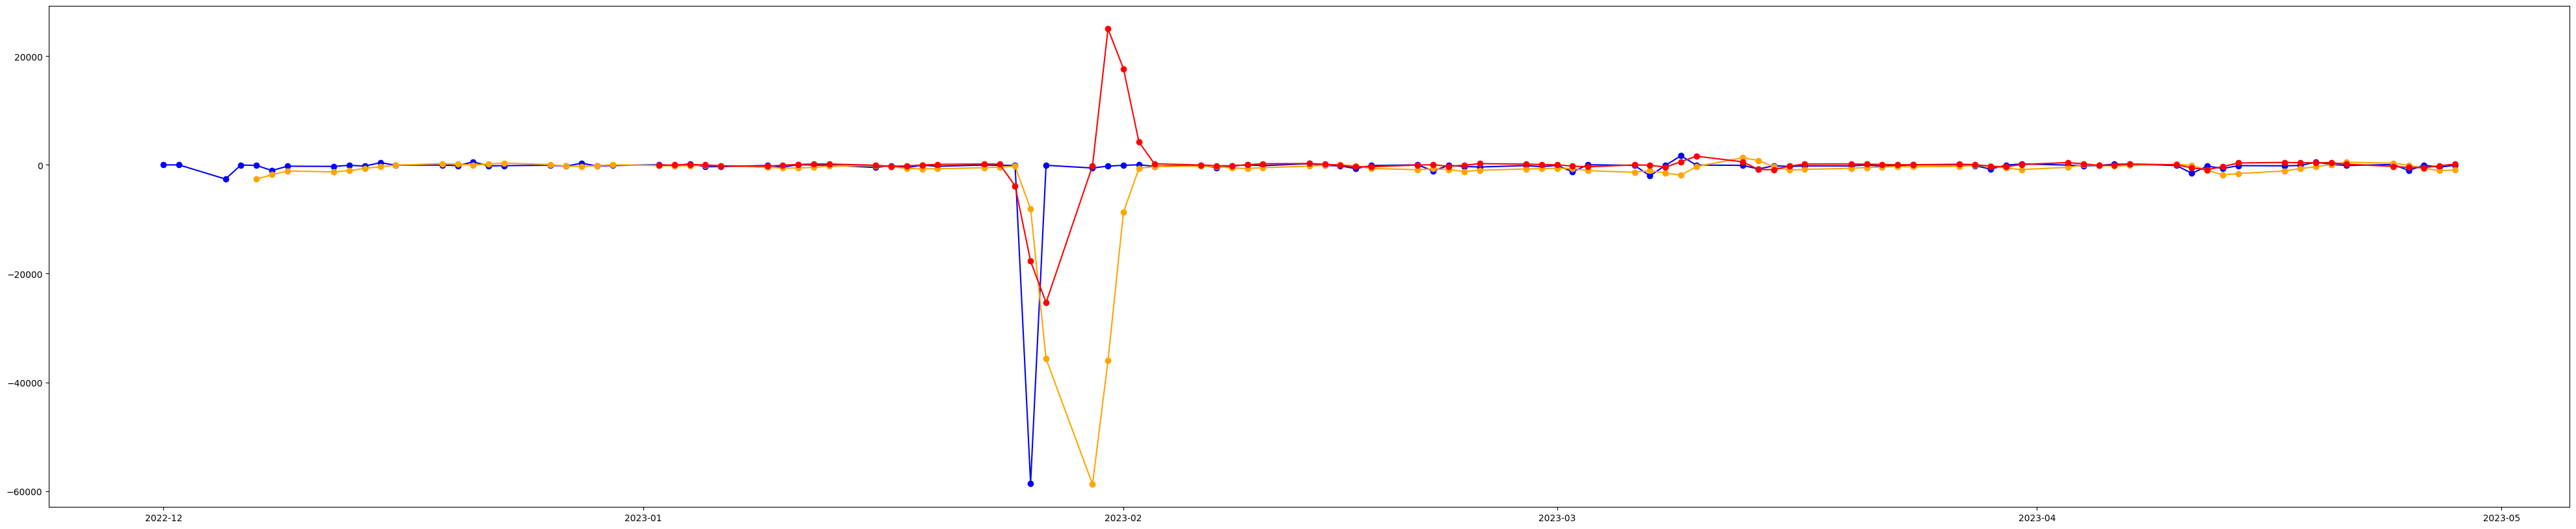

In [747]:
fig = plt.figure(figsize = (50, 10))
plt.xticks(fontsize = 10)

# plt.plot(market_index.index, market_index["INDEX_PRINCIPAL_COMPONENT"], marker = "o", color = "red")
plt.plot(market_index.index, market_index["daily_fluctuation_rate"],
         marker = "o", color = "blue")

# plt.plot(rolling_market_index.index, rolling_market_index["INDEX_PRINCIPAL_COMPONENT"], marker = "o", color = "red")
plt.plot(rolling_market_index.index, rolling_market_index["daily_fluctuation_rate"],
         marker = "o", color = "orange")

plt.plot(ma_market_index.index, ma_market_index["derivative_coefficient"],
         marker = "o", color = "red")
plt.show()

* 주어진 변량의 1일 단위 변동률 값을 구한다.

  같은 50의 증가라도 50에서 100으로 증가할 때의 상황과 1000에서 1050으로 증가할 때의 상황은 구별되어야하기 때문이다.

  단위변동률값을 기준으로 새로운 함수를 세운 뒤 (단위가 일별이므로 1계 미분과 같은 효과), LOESS function을 통해 smoothing한 함수를 미분하여 (2계 미분) 구간 별 미분계수를 구한다. (증가한 정도가 얼마나 큰가, 0에 가까우면 증가(감소)정도가 일정).
  
  이 때의 미분계수크기에 따라 범주화한다. 또, 단위변동률 함수의 근을 갖는 지점으로 증가했다가 감소하는 (원래함수의 첨점)구간도 범주에 포함한다. 범주화한 내용을 토대로 장바구니 분석을 통해 각 뉴스의 키워드, 중요도를 비교한다.

In [748]:
pd.set_option("display.max_row", None)
derivativeIndex.categorizeByCoefficient(percent = 90)

<ipython-input-737-b65cb303d37f>:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.MA_MARKET_INDEX["STABLE_or_DRAMATIC"] = self.MA_MARKET_INDEX["derivative_coefficient"].apply(
<ipython-input-737-b65cb303d37f>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.MA_MARKET_INDEX["raw_fluctuation_rate"] = self.MARKET_INDEX_PC["daily_fluctuation_rate"]
<ipython-input-737-b65cb303d37f>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

INDEX_PRINCIPAL_COMPONENT  daily_fluctuation_rate  \
YYYYMMDD                                                        
2023-01-25                -596.939512             -244.531411   
2023-01-26                -373.329366            -8111.261090   
2023-01-27                -267.753659           -35683.037258   
2023-01-31                 -89.069377           -35987.568514   
2023-02-01                 -11.519817            -8687.968976   
2023-02-02                -305.777667             -622.545713   
2023-03-10                 802.994785             -309.389908   
2023-03-15                 173.391345             -357.085266   
2023-04-12                 -87.379075             -979.462253   

            derivative_coefficient                        interval  \
YYYYMMDD                                                             
2023-01-25            -3866.084408            (-355.895, -138.523]   
2023-01-26           -17719.252924  (-58761.80699999999, -953.577]   
2023-01-27           -25325.272262  (-58761.80699999999, -953.577]   
2023-01-31            25036.918319  (-58761.80699999999, -953.577]   
2023-02-01            17682.511401  (-58761.80699999999, -953.577]   
2023-02-02             4189.620116            (-953.577, -620.632]   
2023-03-10             1603.410927            (-355.895, -138.523]   
2023-03-15             -883.191726            (-620.632, -355.895]   
2023-04-12             -872.953926  (-58761.80699999999, -953.577]   

           STABLE_or_DRAMATIC  raw_fluctuation_rate  CURRENT_SIGN  \
YYYYMMDD                                                            
2023-01-25           DRAMATIC           -100.576647           1.0   
2023-01-26           DRAMATIC         -58568.639170           1.0   
2023-01-27           DRAMATIC            -73.745722           1.0   
2023-01-31           DRAMATIC           -224.165535           1.0   
2023-02-01           DRAMATIC            -74.545895          -1.0   
2023-02-02           DRAMATIC             22.262880          -1.0   
2023-03-10           DRAMATIC            -32.886702           1.0   
2023-03-15           DRAMATIC           -162.326760           1.0   
2023-04-12           DRAMATIC           -219.778061           1.0   

            SIGN_CHANGE  MA_CURRENT_SIGN MA_SIGN_CHANGE  
YYYYMMDD                                                 
2023-01-25   Not Change              1.0     Not Change  
2023-01-26   Not Change              1.0     Not Change  
2023-01-27   Not Change              1.0     Not Change  
2023-01-31   Not Change              1.0     Not Change  
2023-02-01  Sign Change              1.0     Not Change  
2023-02-02  Sign Change              1.0     Not Change  
2023-03-10   Not Change             -1.0    Sign Change  
2023-03-15   Not Change              1.0     Not Change  
2023-04-12   Not Change              1.0     Not Change

In [752]:
pd.set_option("display.max_row", 30)
derivativeIndex.mergeIndexNewsData()

<ipython-input-737-b65cb303d37f>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MARKET_INDEX["YYYYMMDD"] = MARKET_INDEX.index
<ipython-input-737-b65cb303d37f>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MARKET_INDEX["YYYYMMDD"] = MARKET_INDEX["YYYYMMDD"].astype("str")


INDEX_PRINCIPAL_COMPONENT_x  daily_fluctuation_rate  \
0                      -596.939512             -244.531411   
1                      -596.939512             -244.531411   
2                      -596.939512             -244.531411   
3                      -596.939512             -244.531411   
4                      -596.939512             -244.531411   
...                            ...                     ...   
99119                   -87.379075             -979.462253   
99120                   -87.379075             -979.462253   
99121                   -87.379075             -979.462253   
99122                   -87.379075             -979.462253   
99123                   -87.379075             -979.462253   

       derivative_coefficient                        interval  \
0                -3866.084408            (-355.895, -138.523]   
1                -3866.084408            (-355.895, -138.523]   
2                -3866.084408            (-355.895, -138.523]   
3                -3866.084408            (-355.895, -138.523]   
4                -3866.084408            (-355.895, -138.523]   
...                       ...                             ...   
99119             -872.953926  (-58761.80699999999, -953.577]   
99120             -872.953926  (-58761.80699999999, -953.577]   
99121             -872.953926  (-58761.80699999999, -953.577]   
99122             -872.953926  (-58761.80699999999, -953.577]   
99123             -872.953926  (-58761.80699999999, -953.577]   

      STABLE_or_DRAMATIC  raw_fluctuation_rate  CURRENT_SIGN SIGN_CHANGE  \
0               DRAMATIC           -100.576647           1.0  Not Change   
1               DRAMATIC           -100.576647           1.0  Not Change   
2               DRAMATIC           -100.576647           1.0  Not Change   
3               DRAMATIC           -100.576647           1.0  Not Change   
4               DRAMATIC           -100.576647           1.0  Not Change   
...                  ...                   ...           ...         ...   
99119           DRAMATIC           -219.778061           1.0  Not Change   
99120           DRAMATIC           -219.778061           1.0  Not Change   
99121           DRAMATIC           -219.778061           1.0  Not Change   
99122           DRAMATIC           -219.778061           1.0  Not Change   
99123           DRAMATIC           -219.778061           1.0  Not Change   

       MA_CURRENT_SIGN MA_SIGN_CHANGE    YYYYMMDD  \
0                  1.0     Not Change  2023-01-25   
1                  1.0     Not Change  2023-01-25   
2                  1.0     Not Change  2023-01-25   
3                  1.0     Not Change  2023-01-25   
4                  1.0     Not Change  2023-01-25   
...                ...            ...         ...   
99119              1.0     Not Change  2023-04-12   
99120              1.0     Not Change  2023-04-12   
99121              1.0     Not Change  2023-04-12   
99122              1.0     Not Change  2023-04-12   
99123              1.0     Not Change  2023-04-12   

       INDEX_PRINCIPAL_COMPONENT_y SUBCATEGORY  \
0                         0.466059          기술   
1                         0.466059          사회   
2                         0.466059          기술   
3                         0.466059          경제   
4                         0.466059          사회   
...                            ...         ...   
99119                    79.617501          경제   
99120                    79.617501          경제   
99121                    79.617501          경제   
99122                    79.617501          경제   
99123                    79.617501          경제   

                                          TITLE  IMPORTANCE ITEM_NAME  \
0                          머니투데이 오프라인 헤드라인-25일자       47.64       NaN   
1                    코로나 3년, 국민 손으로 넘어온 방역[우보세]       27.15       NaN   
2       "우린 안 올려" 2년 버틴 삼성도 손들었다…갤S23 눈물의 가격 인상       63.04      삼성전자   
3                     전기·가스요금 올해는…에너지공

In [753]:
merge_derivative_news_data = derivativeIndex.mergeIndexNewsData()

<ipython-input-737-b65cb303d37f>:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MARKET_INDEX["YYYYMMDD"] = MARKET_INDEX.index
<ipython-input-737-b65cb303d37f>:101: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  MARKET_INDEX["YYYYMMDD"] = MARKET_INDEX["YYYYMMDD"].astype("str")


In [754]:
# merge_derivative_news_data.to_csv("/content/drive/MyDrive/AfterLearnerProject/DataArchive/merge_derivative_news_data.csv", index = False)

___

<Axes: >

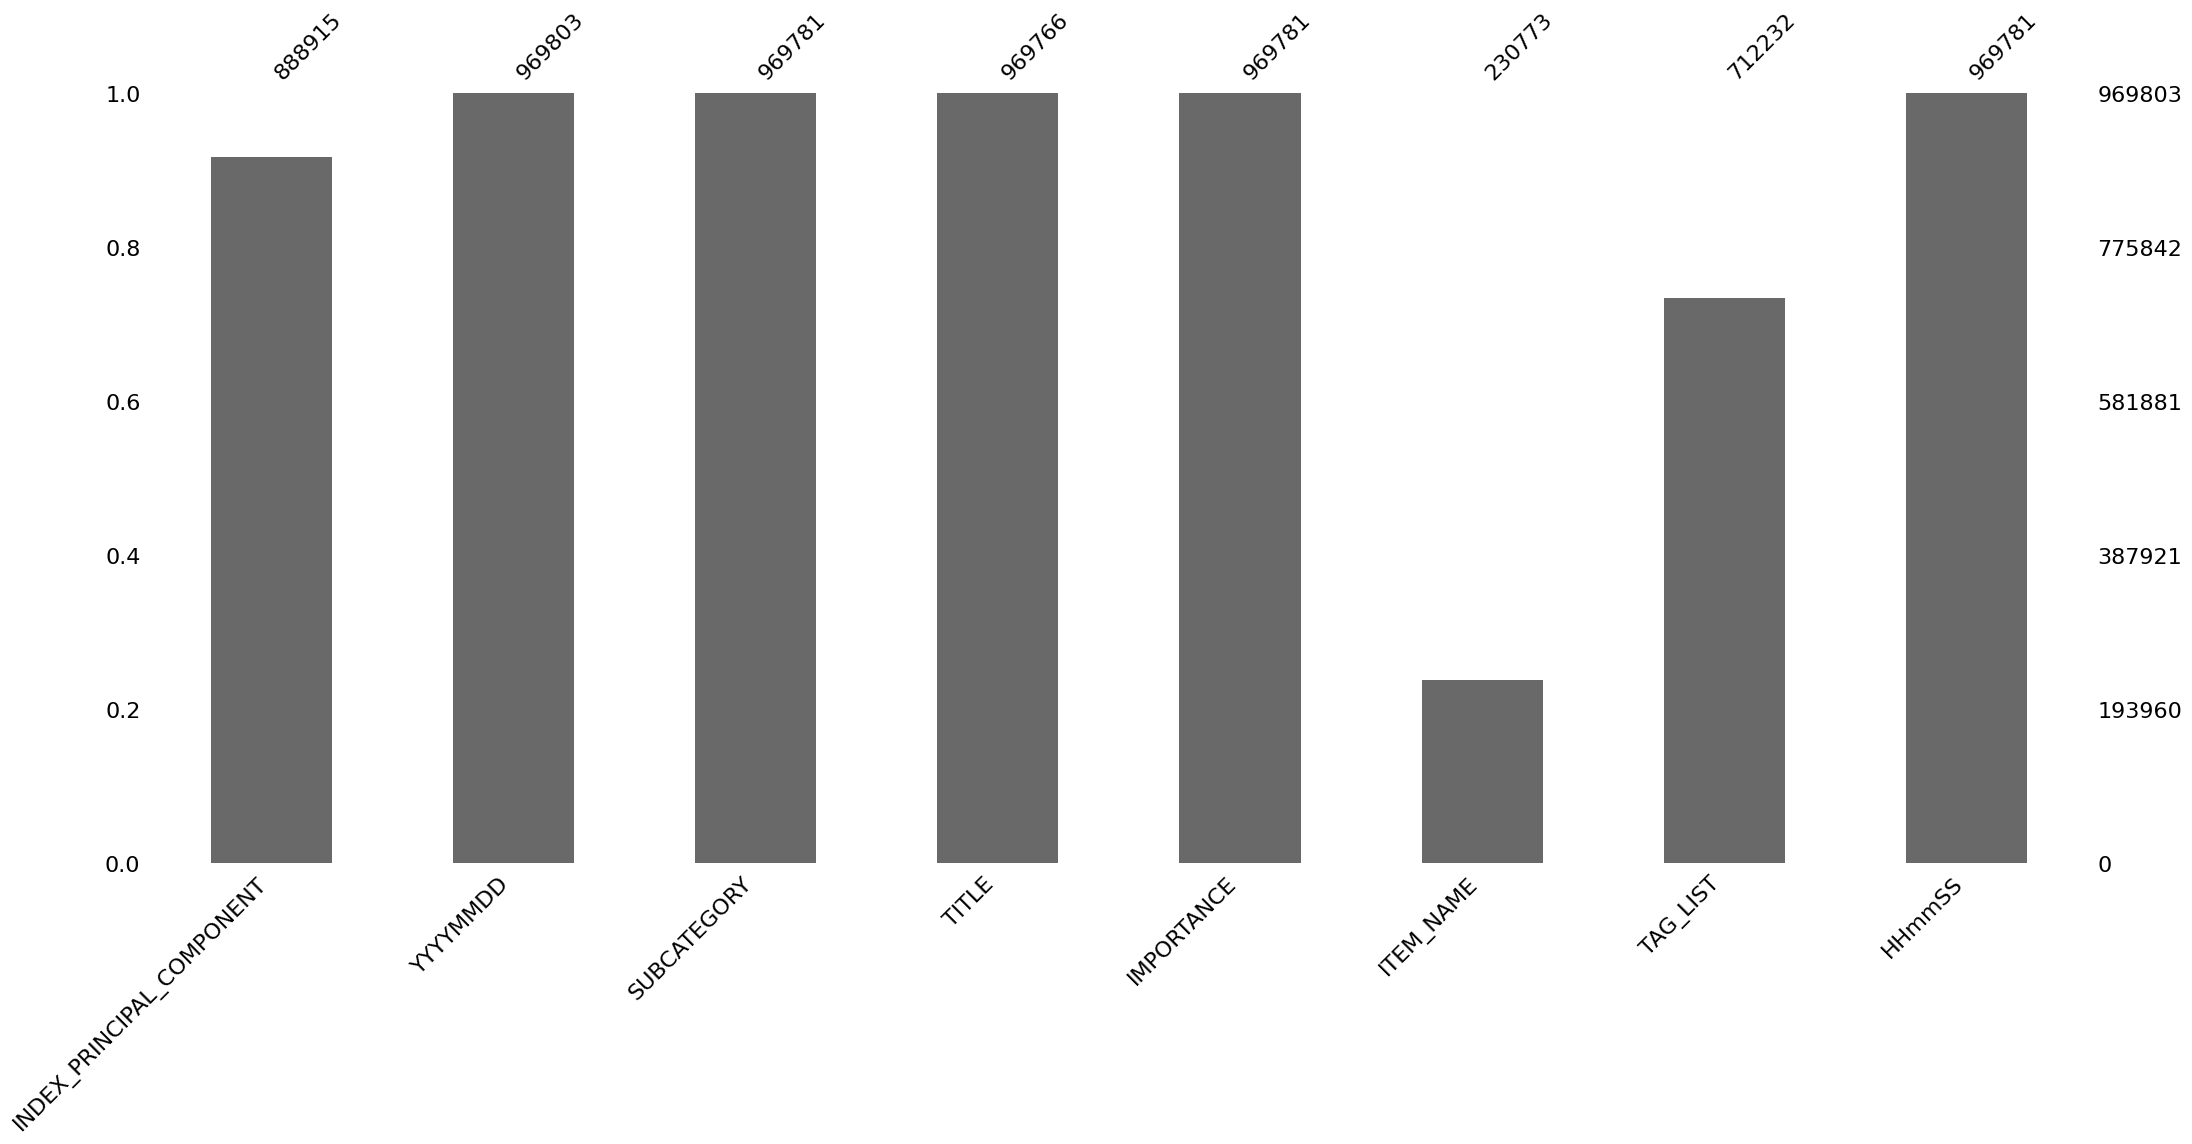

In [4]:
msno.bar(MARKET_INDEX_NEWS)
# MARKET_INDEX_NEWS.isnull().sum()

In [ ]:
NaN_matrix: List = []
i: int = 0
for column in ["ITEM_NAME", "INDEX_PRINCIPAL_COMPONENT", "TAG_LIST"]:
  matrix = MARKET_INDEX_NEWS[MARKET_INDEX_NEWS[column].isnull()]
    # IndexError: list assignment index out of range
  NaN_matrix.append(matrix)

In [ ]:
# ITEM_NAME(뉴스 연관종목명)이 NaN 결측인 데이터프레임
NaN_matrix[0]

INDEX_PRINCIPAL_COMPONENT    YYYYMMDD SUBCATEGORY  \
0                      -21.440589  2022-12-01         NaN   
1                      -21.440589  2022-12-02         NaN   
2                      536.832010  2022-12-05         NaN   
3                      417.266140  2022-12-06         NaN   
4                       23.407171  2022-12-07         NaN   
...                           ...         ...         ...   
969798                        NaN  2023-04-30          기술   
969799                        NaN  2023-04-30          사회   
969800                        NaN  2023-04-30          사회   
969801                        NaN  2023-04-30          정치   
969802                        NaN  2023-04-30          정치   

                                        TITLE  IMPORTANCE ITEM_NAME  \
0                                         NaN         NaN       NaN   
1                                         NaN         NaN       NaN   
2                                         NaN         NaN       NaN   
3                                         NaN         NaN       NaN   
4                                         NaN         NaN       NaN   
...                                       ...         ...       ...   
969798         윤 대통령 "과학기술 협력은 한·미 동맹 새로운 영역"        9.39       NaN   
969799         남산 1·3호 터널 '2000원 통행료' 내년 폐지될까       12.43       NaN   
969800                         서울 반려견 순찰대 발대식       16.72       NaN   
969801  '1세대 영어강사' 오성식 "윤 대통령, 영어 연설에 일가견 있어"       11.96       NaN   
969802        러시아 용병부대 "탄약 지원 안하면 바흐무트서 철수한다"       33.51       NaN   

                                          TAG_LIST    HHmmSS  
0                                              NaN       NaN  
1                                              NaN       NaN  
2                                              NaN       NaN  
3                                              NaN       NaN  
4                                              NaN       NaN  
...                                            ...       ...  
969798  바이오| 디지털| MIT| 스타트업| 창업| 융합| 백신| 코로나19| AI  18:12:09  
969799                                      탄소| 북한  18:13:32  
969800                                         NaN  18:18:43  
969801                                         NaN  20:54:29  
969802                                         NaN  21:08:01  

[739030 rows x 8 columns]

In [ ]:
# INDEX_PRINCIPAL_COMPONENT(종합주가지수의 제1주성분)이 NaN 결측인 데이터프레임
NaN_matrix[1]

INDEX_PRINCIPAL_COMPONENT    YYYYMMDD SUBCATEGORY  \
888915                        NaN  2023-01-01          사회   
888916                        NaN  2023-01-01          정치   
888917                        NaN  2023-01-01          사회   
888918                        NaN  2023-01-01          경제   
888919                        NaN  2023-01-01          사회   
...                           ...         ...         ...   
969798                        NaN  2023-04-30          기술   
969799                        NaN  2023-04-30          사회   
969800                        NaN  2023-04-30          사회   
969801                        NaN  2023-04-30          정치   
969802                        NaN  2023-04-30          정치   

                                        TITLE  IMPORTANCE ITEM_NAME  \
888915        "친구야 새해엔 합격하자"…보신각서 새해 맞이한 10만명       76.09       NaN   
888916           오세훈 시장, 계묘년 새해 맞아 국립서울현충원 참배       43.47       NaN   
888917   [더영상] 눈사람 훔치면 절도죄?…美 '괴물 눈폭풍' 57명 사망       68.08       NaN   
888918       "이미 모든 악재 나왔다"…전문가가 뽑은 내년 뜰 업종은?       58.26   고려아연|영풍   
888919                  [사진]2023년 계묘년(癸卯年) 새해       30.14       NaN   
...                                       ...         ...       ...   
969798         윤 대통령 "과학기술 협력은 한·미 동맹 새로운 영역"        9.39       NaN   
969799         남산 1·3호 터널 '2000원 통행료' 내년 폐지될까       12.43       NaN   
969800                         서울 반려견 순찰대 발대식       16.72       NaN   
969801  '1세대 영어강사' 오성식 "윤 대통령, 영어 연설에 일가견 있어"       11.96       NaN   
969802        러시아 용병부대 "탄약 지원 안하면 바흐무트서 철수한다"       33.51       NaN   

                                          TAG_LIST    HHmmSS  
888915                                   경찰| 코로나19  00:57:58  
888916                                         NaN  06:00:00  
888917               경찰| 프랜차이즈| SNS| 소셜네트워크서비스| 마약  06:10:00  
888918        건설| 반도체| 2차전지| 은행| 부동산| 자동차| 인터넷| 부실  07:03:00  
888919                                         NaN  07:30:00  
...                                            ...       ...  
969798  바이오| 디지털| MIT| 스타트업| 창업| 융합| 백신| 코로나19| AI  18:12:09  
969799                                      탄소| 북한  18:13:32  
969800                                         NaN  18:18:43  
969801                                         NaN  20:54:29  
969802                                         NaN  21:08:01  

[80888 rows x 8 columns]

In [ ]:
# TAG_LIST(종합주가지수의 제1주성분)이 NaN 결측인 데이터프레임
NaN_matrix[2]

INDEX_PRINCIPAL_COMPONENT    YYYYMMDD SUBCATEGORY  \
0                      -21.440589  2022-12-01         NaN   
1                      -21.440589  2022-12-02         NaN   
2                      536.832010  2022-12-05         NaN   
3                      417.266140  2022-12-06         NaN   
4                       23.407171  2022-12-07         NaN   
...                           ...         ...         ...   
969782                        NaN  2023-04-30          사회   
969783                        NaN  2023-04-30          경제   
969800                        NaN  2023-04-30          사회   
969801                        NaN  2023-04-30          정치   
969802                        NaN  2023-04-30          정치   

                                        TITLE  IMPORTANCE ITEM_NAME TAG_LIST  \
0                                         NaN         NaN       NaN      NaN   
1                                         NaN         NaN       NaN      NaN   
2                                         NaN         NaN       NaN      NaN   
3                                         NaN         NaN       NaN      NaN   
4                                         NaN         NaN       NaN      NaN   
...                                       ...         ...       ...      ...   
969782         입양 딸·양동생 추행…'성범죄' 부자 1심서 중형 선고       12.01       NaN      NaN   
969783             하나금융, 경북 칠곡에 '왜관하나어린이집' 개원       11.00       NaN      NaN   
969800                         서울 반려견 순찰대 발대식       16.72       NaN      NaN   
969801  '1세대 영어강사' 오성식 "윤 대통령, 영어 연설에 일가견 있어"       11.96       NaN      NaN   
969802        러시아 용병부대 "탄약 지원 안하면 바흐무트서 철수한다"       33.51       NaN      NaN   

          HHmmSS  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
...          ...  
969782  08:46:12  
969783  10:17:18  
969800  18:18:43  
969801  20:54:29  
969802  21:08:01  

[257571 rows x 8 columns]

In [ ]:
MARKET_INDEX_NEWS["TAG_LIST"]
# .unique()

NameError: ignored